In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint
import time

import src.mod_models as mm
import src.mod_evolution as me
import src.mod_visualization as mv
import src.mod_stimulation as ms
from src.mod_models import logger
import inputools.Trajectory as it
from tools.utils import clf, tqdm_enumerate

%load_ext autoreload
%autoreload 2

2023-12-12 21:59:06 | logger set up
2023-12-12 21:59:06 | cache path = /Users/daniekru/Research/lab/cache/
2023-12-12 21:59:06 | OS: mac


@toolpack


## Inputs
---

In [12]:
layer = it.InputLayer(N=9, kind='hd', sigma=0.01)
logger.info(layer)

2023-11-29 19:21:58 | InputLayer(N=9, kind=hd, sigma=0.01)


2023-12-13 13:15:03 | Layer(N=10 [10, Nz=0], kind=hd)


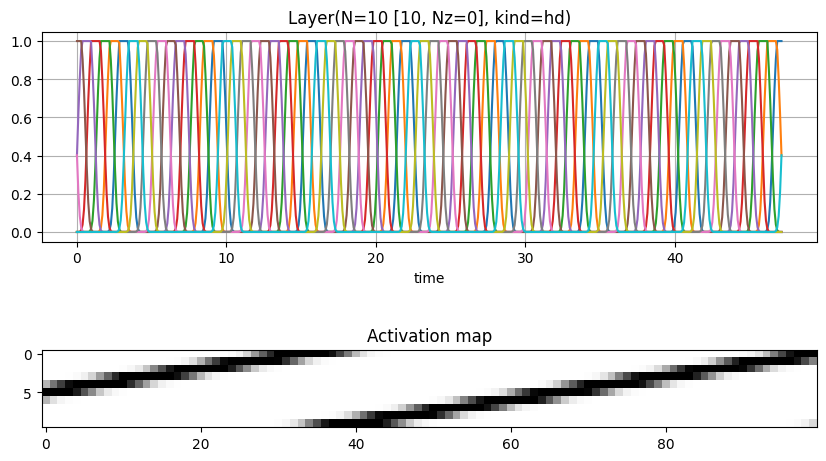

In [230]:
layer = it.HDLayer(N=10, Nz=0, sigma=0.01)
logger.info(layer)
layer.plot(Tmax=15*np.pi, size=500)

2023-12-06 15:55:54 | Layer(N=9 [9, Nz=0], kind=place)


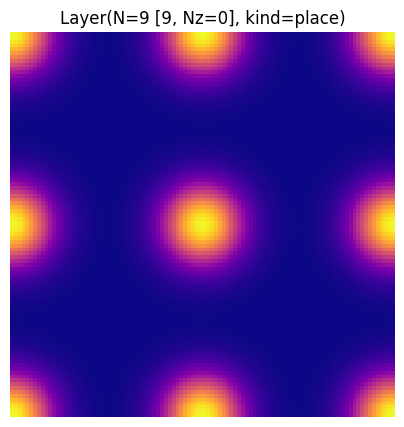

In [108]:
layer = it.PlaceLayer(N=9, sigma=0.01)
logger.info(layer)

layer.plot(kind=None, size=400,
           sigmoid_beta=0.3, sigmoid_alpha=0.5)

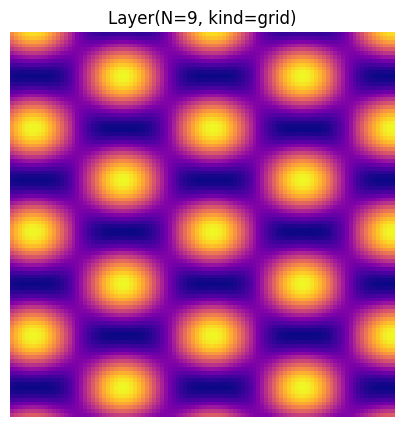

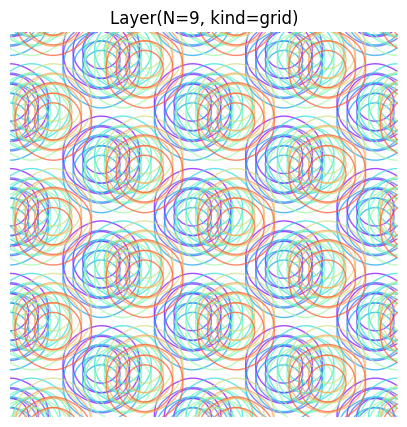

In [913]:
layer = it.GridLayer(N=9, sigma=6., 
                     scale=np.array([1.47, 0.52]))
layer.plot(size=200, kind=None, 
           sigmoid_beta=1, sigmoid_alpha=0.)
layer.plot(size=200, kind='contour')

#### 2D positions

**Trajectory**

2023-12-13 23:27:16 | dict_keys(['trajectory', 'direction', 'speed', 'distance'])
2023-12-13 23:27:16 | distance=50.00 [avg=0.00050]
2023-12-13 23:27:16 | step=100000


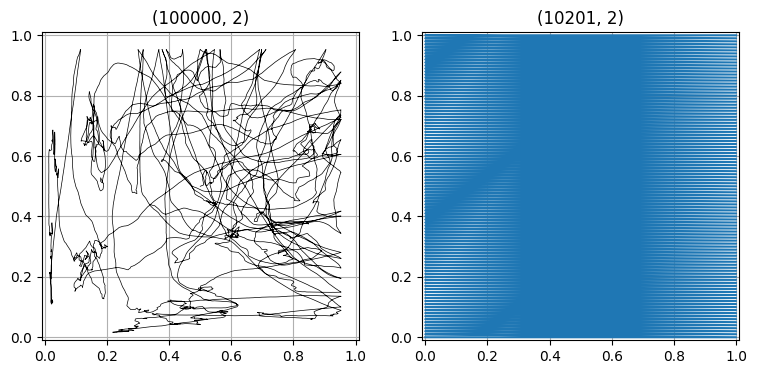

In [1103]:
# Create an animal
animal = it.AnimalTrajectory(dt=0.05, 
                             prob_turn=0.1, 
                             prob_speed=0.0,
                             prob_rest=0.0, 
                             day_cycle=False)

# Create a trajectory
trajectory = animal.make_trajectory(duration=100_000, whole=False, dx=1, normalize=0, turning_scale=1, speed=1)
whole_track = it.AnimalTrajectory.whole_walk(dx=0.01)

# analysis
analysis = animal.analyse_trajectory(trajectory=trajectory)
logger(analysis.keys())
logger(f"distance={analysis['distance'].sum():.2f} [avg={analysis['distance'].mean():.5f}]")
logger(f"step={len(analysis['distance'])}")

# Plot the trajectory
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.plot(trajectory[:, 0], trajectory[:, 1], '-k', lw=0.5)
plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()
plt.title(trajectory.shape)

plt.subplot(122)
plt.plot(whole_track[:, 0], whole_track[:, 1])
plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()
plt.title(whole_track.shape)
plt.show()


**Visualization**

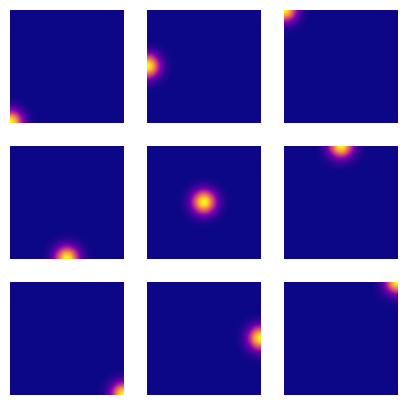

In [288]:
def plot_activation(activation):

    size, N = activation.shape
    sqrtsize = int(np.sqrt(size))

    _, axs = plt.subplots(int(np.sqrt(N)), int(np.sqrt(N)), figsize=(5, 5))
    i = 0
    for row in axs:
        for ax in row:
            ax.imshow(np.flip(activation[:, i].reshape(sqrtsize, sqrtsize), axis=0), cmap='plasma')
            ax.axis('off')
            i += 1
    plt.show()


# input
layer = it.PlaceLayer(N=9, sigma=0.01)
A = layer.parse_trajectory(trajectory=whole_track)
plot_activation(A)

In [987]:
# input
layer = it.PlaceLayer(N=9, sigma=0.01)
A = layer.parse_trajectory(trajectory=trajectory)

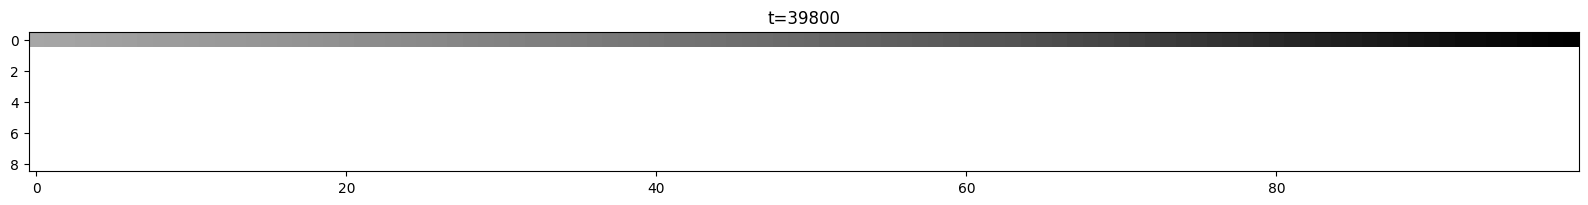

In [988]:
for t in range(0, len(A)-100, 100):
    clf()
    plt.figure(figsize=(20, 5))
    plt.imshow(A[t:t+100, :].T, cmap='Greys')
    plt.title(f"{t=}")
    plt.pause(0.1)

2023-12-13 19:22:18 | dict_keys(['trajectory', 'direction', 'speed', 'distance'])
2023-12-13 19:22:18 | distance=9.44
2023-12-13 19:22:18 | step=10000


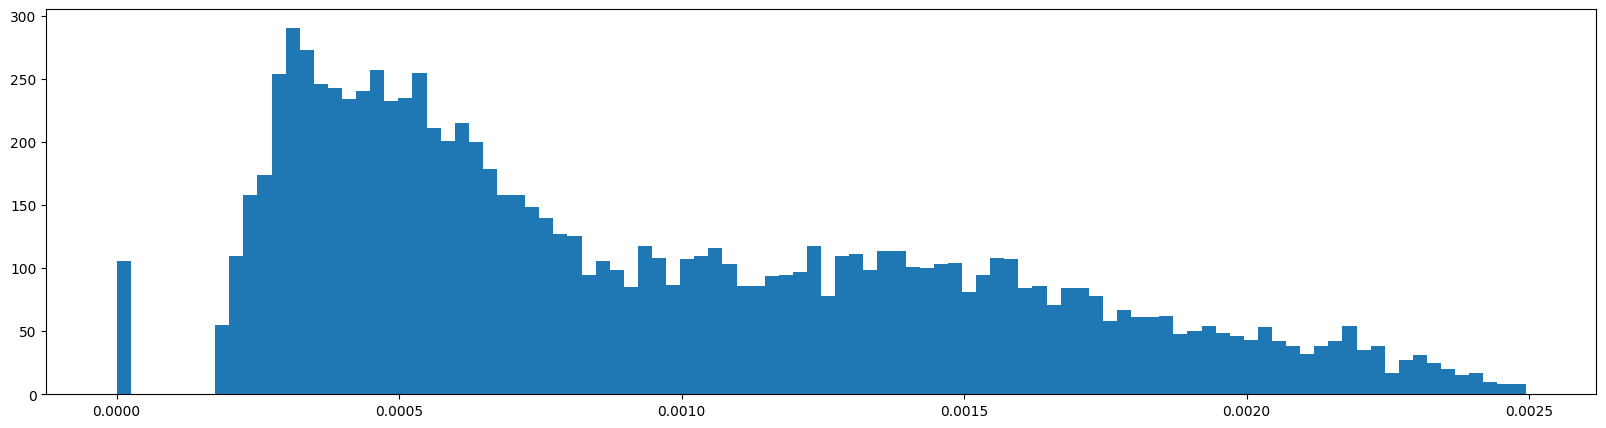

In [339]:
analysis = animal.analyse_trajectory(trajectory=trajectory)
logger(analysis.keys())
logger(f"distance={analysis['distance'].sum():.2f}")
logger(f"step={len(analysis['distance'])}")
plt.figure(figsize=(20, 5))
plt.hist(analysis['speed'], bins=100);

## Simulation I

#### Models

In [5]:
model = mm.RateNetwork3(N=N, Nj=Nj, 
                       gain=4,
                       bias=2,
                       lr=1,
                       lr_beta=1.,
                       rule='hebb',
                       wff_std=0.01,
                       wff_min=0.01,
                       wff_max=3.,
                       wff_const=7,
                       wff_tau=10,
                       loc_magnitude=2)
logger.info(model)

2023-11-29 18:18:10 | RateNetwork3(N=4, Nj=6, rule=hebb) [oyfjj]


###### Load model from evolution

In [3]:
genome = me.load_best_individual()
genome

2023-11-24 15:02:47 | Available files in /Users/daniekru/Research/lab/PCNN/cache:
2023-11-24 15:02:47 | 0: best_2239_r3.json
2023-11-24 15:02:47 | 1: best_2220_r3.json
2023-11-24 15:02:47 | 2: best_2311_1657_r3.json
2023-11-24 15:02:47 | 3: best_2238_r3.json
2023-11-24 15:02:47 | 4: best_2233_r3.json
2023-11-24 15:02:47 | 5: best_2215_r3.json
2023-11-24 15:02:47 | 6: best_ind_2238.json
2023-11-24 15:02:47 | 7: best_2342_r3.json
2023-11-24 15:02:47 | 8: best_ind_2311.json
2023-11-24 15:02:47 | 9: top_ij_1.json
2023-11-24 15:02:47 | 10: best_2227_r3.json
2023-11-24 15:02:47 | 11: best_2218_r3.json
2023-11-24 15:02:47 | 12: best_2149_r3.json
2023-11-24 15:02:47 | 13: best_2226_r3.json
2023-11-24 15:02:47 | 14: best_2132_r3.json
2023-11-24 15:02:47 | 15: best_2311_1731_r3.json
2023-11-24 15:02:47 | 16: best_2411_1502_r3.json
2023-11-24 15:02:47 | 17: best_2129_r3.json
2023-11-24 15:02:47 | 18: best_2224_r3.json
2023-11-24 15:02:47 | 19: best_2213_r3.json


Choose a file:  16


2023-11-24 15:02:59 | Best individual loaded from best_2411_1502_r3.json in /Users/daniekru/Research/lab/PCNN/cache.


{'gain': 15.8,
 'bias': 1.0,
 'lr': 0.65999,
 'tau': 50.0,
 'wff_std': 0.001,
 'wff_min': 0.0,
 'wff_max': 3.0,
 'wff_tau': 132,
 'rule': 'hebb',
 'std_tuning': 0.001,
 'soft_beta': 0.1,
 'dt': 0.053,
 'N': 6,
 'Nj': 6}

In [4]:
model = mm.RateNetwork2(**genome)
logger.info(model)

2023-11-24 15:03:30 | RateNetwork2(N=6, Nj=6, rule=hebb)


#### Training

KeyboardInterrupt: 

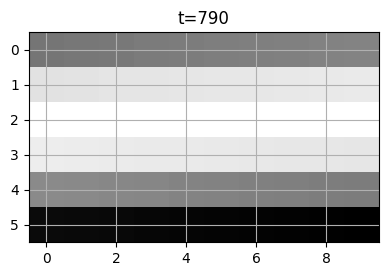

In [7]:
model.reset()


record = np.zeros((4, len(X)))
X2 = np.zeros((len(X) + 10, Nj))

for t, x in enumerate(X):
    
    model.step(x=x.reshape(-1, 1))
    record[0, t] = (model.Wff @ x.reshape(-1, 1))[0]
    record[1, t] = (model.Wff @ x.reshape(-1, 1))[1]
    record[2, t] = model.u[0]
    record[3, t] = model.u[1]
    X2[10:t+10] = X[:t]


    if t % 10 == 0:
        
        clf()
        plt.figure(figsize=(15, 6))
        plt.tight_layout()
        
        plt.subplot(221)
        plt.imshow(X2.T[:, t-10:t], cmap="Greys")
        #plt.ylim((0, 1))
        plt.title(f"{t=}")
        #plt.xlabel("time")
        plt.grid()
        
        plt.subplot(222)
        plt.axvline(0, color='black', alpha=0.3)
        plt.plot(np.flip(model.Wff[0], axis=0), range(Nj), '-b', alpha=0.4)
        plt.plot(np.flip(model.Wff[0], axis=0), range(Nj), 'ob', alpha=0.4)
        plt.plot(np.flip(model.Wff[1], axis=0), range(Nj), '-r', alpha=0.4)
        plt.plot(np.flip(model.Wff[1], axis=0), range(Nj), 'or', alpha=0.4)
        plt.title(f"Weights")
        plt.yticks(())
        plt.xlim((-5, 7))
        #plt.xlabel("intensity")
        plt.grid()
        
        plt.subplot(223)
        #plt.plot(range(t), record[0, :t])
        #plt.plot(range(t), record[1, :t])
        plt.imshow(model.Wff, cmap="plasma")
        plt.title("Input $W^{ff}$@$x$ : "+f"{record[0, t]:.3f}, {record[1, t]:.3f}")
        #plt.ylim((0, 20))
        plt.grid()
        
        plt.subplot(224)
        plt.plot(range(t), record[2, :t])
        plt.plot(range(t), record[3, :t])
        plt.title(f"$u$={np.around(model.u.T, 3)} - I={model.I_loc.T}")
        plt.ylim((0, 1.3))
        plt.grid()
        plt.pause(0.001)

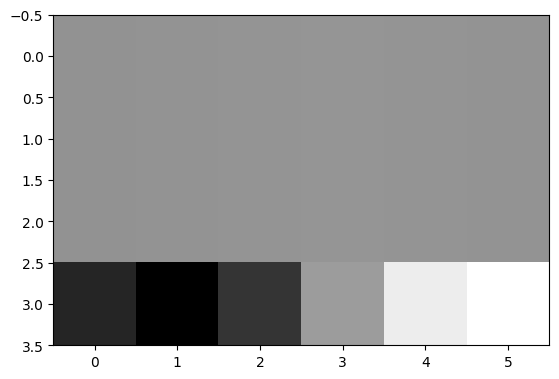

In [151]:
plt.imshow(model.Wff, cmap="Greys");

### Local stimulation

#### Supra-threshold

In [251]:
N = 5
T = 100

x = np.arange(N)
y = np.zeros((T, N))
for t in range(T):
    y[t, np.random.randint(0, N)] = 1

#### Sub-threshold

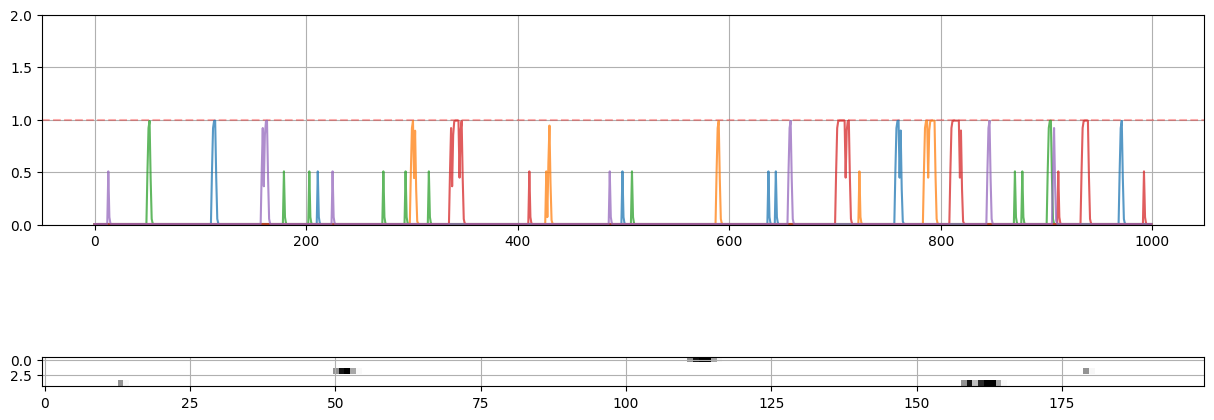

In [1057]:
def subthr(plot=True, noise=True):
    
    T = 1000
    N = 5
    thr = 1.
    u = np.ones((N, 1))*1e-8
    tau_0 = 30.
    tau = tau_0
    curr = np.zeros((N+1, 1))
    
    record = np.zeros((T, N))
    for t in range(T):
    
        p = np.array((u).flatten().tolist() + [1])
        p = p/p.sum()
        curr *= 0
        curr[np.random.choice(range(N+1), p=p, size=1)] = 1.
        u += (-u)/tau + int(noise)*np.random.normal(0., 0.1, (N, 1)) + curr[:-1]
    
        # activation
        u = 1 / (1 + np.exp(-5*(u - thr)))
    
        # adaptive threshold
        #tau += (1*u + tau_0*(1-u) - tau) / 2
        
        # record
        record[t, :] = u.flatten()
    
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(211)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(T), record[:, i], alpha=0.75)
        
        plt.grid()
        plt.ylim((0, 2))

        plt.subplot(212)
        plt.imshow(record[:200].T, cmap='Greys')
        plt.grid()
        plt.show()

    return record

record = subthr(plot=True, noise=0)

**Analysis**

In [1058]:
nb = 100
sum1 = np.zeros((nb, 2))
for i in tqdm(range(nb)):
    rec = subthr(plot=False)
    rec = np.where(rec > 0.4, 1, 0)
    sum1[i] = [rec.sum(axis=1).mean(), 
               (np.exp(rec.sum(axis=0))/np.exp(rec.sum(axis=0)).sum()).std()]

print("With noise")
print(f"mean (over T): {sum1.mean(axis=0)[0]:.3f}")
print(f"std (over N): {sum1.mean(axis=0)[1]:.3f}")

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.88it/s]

With noise
mean (over T): 0.075
std (over N): 0.367


In [1059]:
nb = 100
sum1 = np.zeros((nb, 2))
for i in tqdm(range(nb)):
    rec = subthr(plot=False, noise=False)
    rec = np.where(rec > 0.4, 1, 0)
    sum1[i] = [rec.sum(axis=1).mean(), 
               (np.exp(rec.sum(axis=0))/np.exp(rec.sum(axis=0)).sum()).std()]

print("Without noise")
print(f"mean (over T): {sum1.mean(axis=0)[0]:.3f}")
print(f"std (over N): {sum1.mean(axis=0)[1]:.3f}")

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.97it/s]

Without noise
mean (over T): 0.070
std (over N): 0.364


In [724]:
sums = []
for i in range(N):
    sums += [np.where(record[:, i] > 0.99, 1, 0).sum()]
print('no noise ', sums, sum(sums))

no noise  [0, 0, 9, 7, 10] 26


In [735]:
sums = []
for i in range(N):
    sums += [np.where(record[:, i] > 0.99, 1, 0).sum()]
print('noise ', sums, sum(sums))

noise  [3, 9, 1, 0, 5] 18


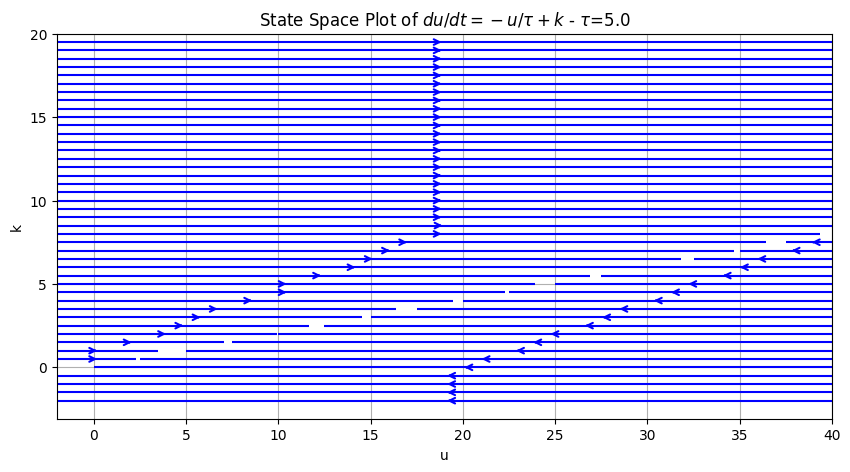

In [284]:
# Parameters
u_range = np.linspace(-2, 40, 40)
k_range = np.linspace(-2, 20, 30)

# Create a grid of u and k values
U, K = np.meshgrid(u_range, k_range)

# Time constant
tau = 5.0

# Define the ODE
dU_dt = -U/tau + K

# Plot
plt.figure(figsize=(10, 5))
plt.streamplot(U, K, dU_dt, np.zeros_like(dU_dt), density=1.5, arrowstyle='->', color='blue')
plt.xlabel('u')
plt.ylabel('k')
plt.title(f"State Space Plot of $du/dt = -u/\\tau + k$ - $\\tau$={tau}")
plt.grid(True)
plt.show()

#### Oscillatory

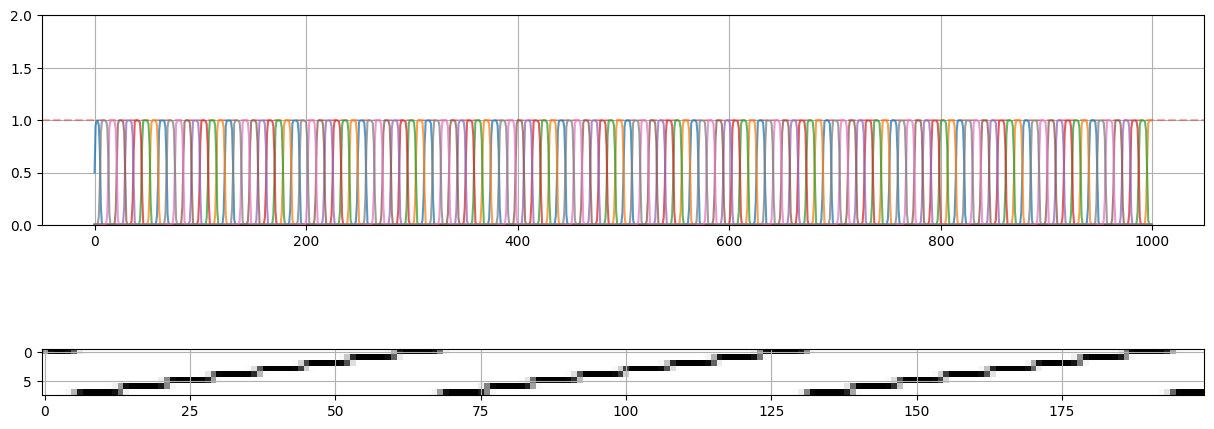

In [8]:
T = 1000
dt = 0.1
N = 8
tuning = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)

thr = 1.
u = np.ones((N, 1))*1e-8
tau_0 = 30.
tau = tau_0
curr = np.zeros((N+1, 1))

record = np.zeros((T, N))
for t in range(T):

    u += (-u)/tau + np.exp(-(np.cos(t*dt + tuning) - 1)**2/0.01)

    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # adaptive threshold
    #tau += (1*u + tau_0*(1-u) - tau) / 2
    
    # record
    record[t, :] = u.flatten()

plt.figure(figsize=(15, 6))
plt.subplot(211)
plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
for i in range(N):
    plt.plot(range(T), record[:, i], alpha=0.75)

plt.grid()
plt.ylim((0, 2))

plt.subplot(212)
plt.imshow(record[:200].T, cmap='Greys')
plt.grid()
plt.show()


#### + Lateral inhibition

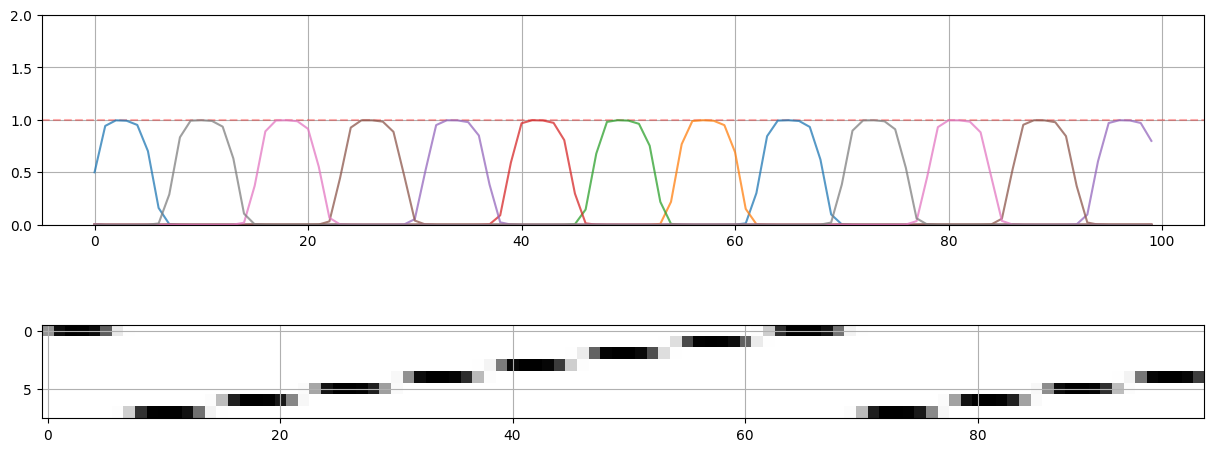

In [69]:
T = 100
dt = 0.1
N = 8
tuning = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)

thr = 1.
u = np.ones((N, 1))*1e-8
tau_0 = 30.
tau = tau_0
curr = np.zeros((N+1, 1))

# lateral
Wr = -1  * (np.ones((N, N)) - np.eye(N))

record = np.zeros((T, N))
for t in range(T):

    u += (-u)/tau + np.exp(-(np.cos(t*dt + tuning) - 1)**2/0.01) + Wr @ u

    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # adaptive threshold
    #tau += (1*u + tau_0*(1-u) - tau) / 2
    
    # record
    record[t, :] = u.flatten()

plt.figure(figsize=(15, 6))
plt.subplot(211)
plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
for i in range(N):
    plt.plot(range(T), record[:, i], alpha=0.75)

plt.grid()
plt.ylim((0, 2))

plt.subplot(212)
plt.imshow(record[:200].T, cmap='Greys')
plt.grid()
plt.show()


### Plasticity study

#### Only plasticity

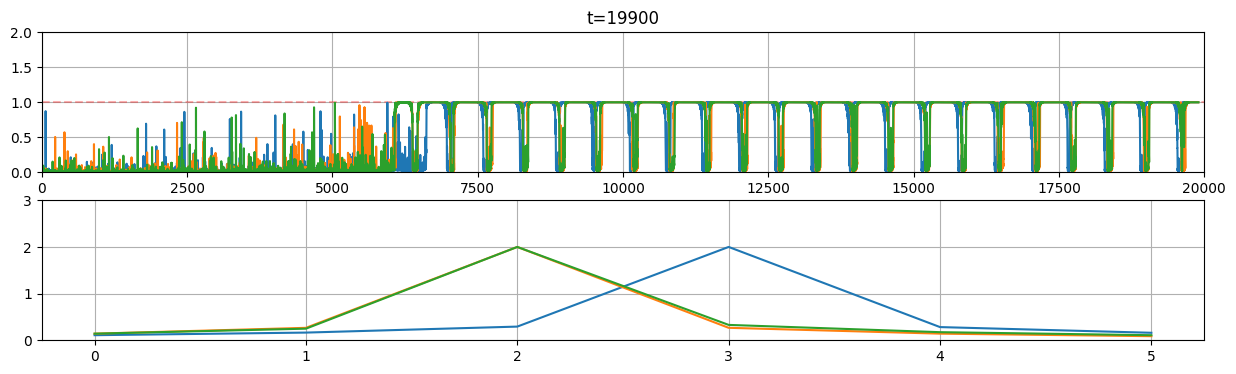

In [59]:
N = 3
T = len(X)

# neural settings
thr = 1.
u = np.ones((N, 1))*1e-8
W = np.ones((N, Nj))*1e-3
tau = 30.
lr = 0.01

# plasticity
rule = 'hebb'
beta = 10

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    u += (-u)/tau + W @ x.reshape(-1, 1) + np.random.normal(0, 0.3, size=(N, 1))**2
    
    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # plasticity
    if rule == 'hebb':
        dw = u * x
    elif rule == 'oja':
        dw = u * x - W @ (x * x)

    W += lr * dw * (np.exp(beta*W)/np.exp(beta*W).sum(axis=1, keepdims=True))

    W = W.clip(1e-3, 2e0)

    # record
    record[t] = u.flatten()

    if t % 100 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(211)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, 2))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=}")
        
        plt.subplot(212)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), W[i])

        plt.ylim((0, 3))
        plt.grid()
        plt.pause(0.0001)

#### Plasticity + oscillatory local input

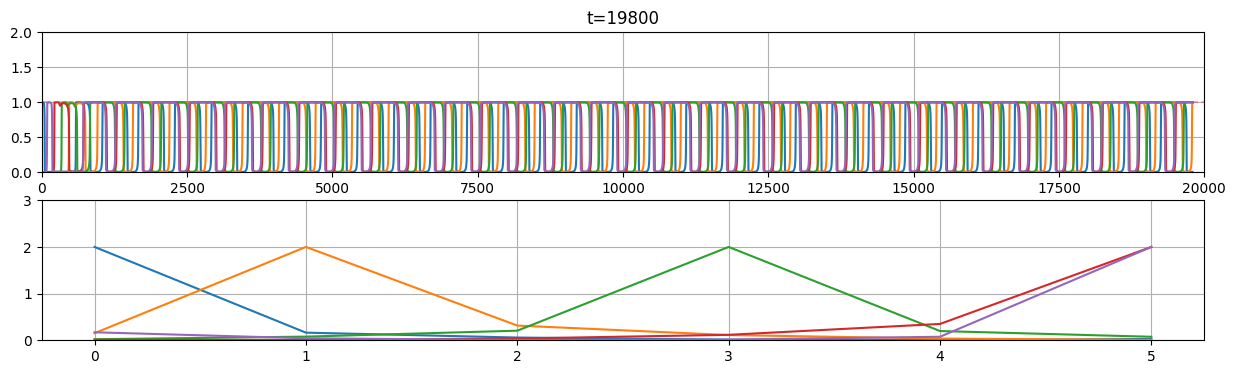

In [60]:
N = 5
T = len(X)

# neural settings
thr = 1.
u = np.ones((N, 1))*1e-8
W = np.ones((N, Nj))*1e-3
tau = 30.
lr = 0.01

# tuning
tuning = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)

# plasticity
rule = 'hebb'
beta = 10

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    u += (-u)/tau + W @ x.reshape(-1, 1) + np.exp(-(np.cos(t*0.01 + tuning) - 1)**2/0.01)
    
    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # plasticity
    if rule == 'hebb':
        dw = u * x
    elif rule == 'oja':
        dw = u * x - W @ (x * x)

    W += lr * dw * (np.exp(beta*W)/np.exp(beta*W).sum(axis=1, keepdims=True))

    W = W.clip(1e-3, 2e0)

    # record
    record[t] = u.flatten()

    if t % 200 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(211)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, 2))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=}")
        
        plt.subplot(212)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), W[i])

        plt.ylim((0, 3))
        plt.grid()
        plt.pause(0.0001)

#### Lateral inhibition

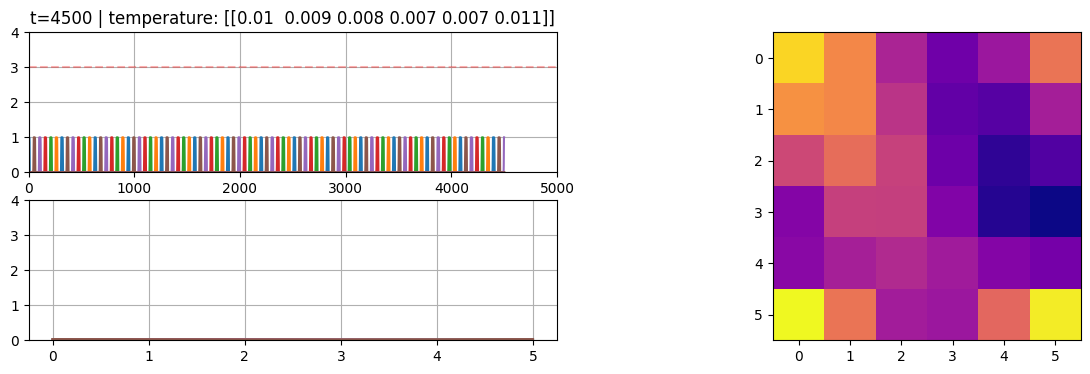

In [211]:
N = 6
T = len(X)

# neural settings
thr = 3.
u = np.ones((N, 1))*1e-8
W = np.ones((N, Nj))*1e-3
wmax = 3
tau_0 = 20.
tau = tau_0
lr = 0.01

# tuning
tuning_0 = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)
tuning = tuning_0.copy()

# plasticity
rule = 'hebb'
beta = 10
temp = np.zeros((N, 1))

# lateral inhibition
Wr = -1 * (np.ones((N, N)) - np.eye(N))

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    u += (-u)/tau + W @ x.reshape(-1, 1) + thr * (1 - temp) * np.exp(
        - (np.cos(t*0.02 + tuning) - 1)**2/0.001) + Wr @ u #+ np.random.normal(0, 0.2, (N, 1))**2
    
    # activation
    u = 1 / (1 + np.exp(-7*(u - thr)))

    # time constant
    #tau += (1*u + tau_0*(1-u) - tau) / 2

    # temperature
    temp = (W.max(axis=1) / wmax).reshape(-1, 1)

    # weight decay
    W += (- W / 500) * (1 - temp)

    # plasticity
    if rule == 'hebb':
        dw = u * x
    elif rule == 'oja':
        dw = u * x - W @ (x * x)

    W += lr * dw * (np.exp(beta*W)/np.exp(beta*W).sum(axis=1, keepdims=True))

    W = W.clip(0., wmax)

    # record
    record[t] = u.flatten()

    if t % 500 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(221)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, thr+1))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=} | temperature: {np.around(temp.T, 3)}")
        
        plt.subplot(223)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), W[i])

        plt.ylim((0, wmax+1))
        plt.grid()

        plt.subplot(122)
        plt.imshow(W, cmap='plasma')
        plt.pause(0.0001)

## Simulation II - *model 4*
---

In [495]:
N = 6
Nj = 10

#### load model

In [1981]:
file = me.load_best_individual()
info, genome = file['info'], file['genome']
pprint(file)

2023-12-01 11:27:21 | Available files in /Users/daniekru/Research/lab/PCNN/cache:
2023-12-01 11:27:21 | 0: top_2311.json
2023-12-01 11:27:21 | 1: best_20.json
2023-12-01 11:27:21 | 2: top_2238.json
2023-12-01 11:27:21 | 3: best_8.json
2023-12-01 11:27:21 | 4: top_ij_1.json
2023-12-01 11:27:21 | 5: best_6.json
2023-12-01 11:27:21 | 6: best_7.json
2023-12-01 11:27:21 | 7: top_2239_r3.json


Choose a file:  3


2023-12-01 11:27:24 | Best individual loaded from best_8.json in /Users/daniekru/Research/lab/PCNN/cache.


{'genome': {'DA_tau': 3,
            'N': 6,
            'Nj': 6,
            'bias': 3.0,
            'bias_decay': 316,
            'bias_scale': 0.72,
            'dt': 0.053,
            'gain': 25.0,
            'lr': 0.001,
            'rule': 'hebb',
            'soft_beta': 50.0,
            'std_tuning': 0.005,
            'tau': 4.0,
            'wff_max': 3.5,
            'wff_min': 0.0,
            'wff_std': 0.001,
            'wff_tau': 300},
 'info': {'date': '01/12/2023 at 11:20',
          'game': 'Track2D(fitness_size=1)',
          'model': 'RateNetwork4'}}


**tweak**

In [2313]:
genome['N'] = 100
genome['Nj'] = 100

#### new model

In [496]:
genome = {'gain': 30.0,
 'bias': 2.5,
 'lr': 0.075,
 'tau': 10,
 'wff_std': 0.001,
 'wff_min': 0.0,
 'wff_max': 3.5,
 'wff_tau': 750,
 'rule': 'hebb',
 'std_tuning': 0.01,
 'soft_beta': 30,
 'dt': 0.00035,
 'N': N,
 'Nj': Nj,
 'DA_tau': 3,
 'bias_scale': 0.055,
 'bias_decay': 75,
}

#### settings

2023-12-11 15:00:18 | RateNetwork4(N=6, Nj=10, rule=hebb) [VIUnl]


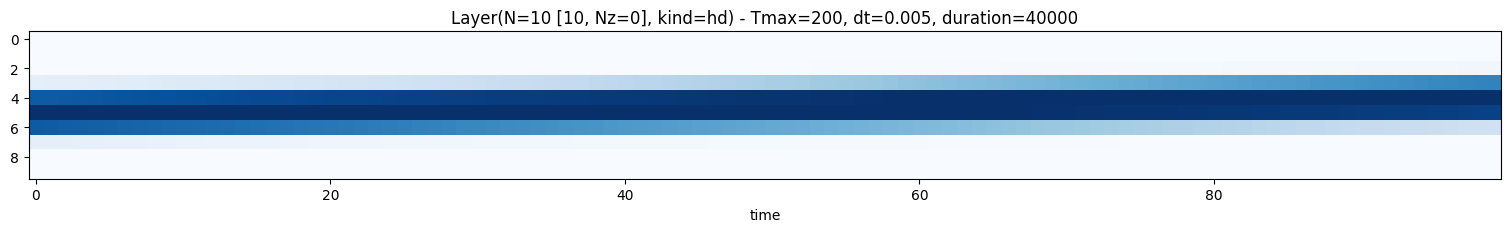

In [497]:
# model
model = mm.RateNetwork4(**genome)
logger.info(model)

N = genome['N']
Nj = genome['Nj']

# input
Tmax = 200
dt = 0.005
layer = it.HDLayer(N=Nj, sigma=0.05)
trajectory = np.arange(0, Tmax, dt)
duration = len(trajectory)
X = layer.parse_trajectory(trajectory=trajectory)
plt.figure(figsize=(19, 4))
plt.imshow(X[:100].T, cmap='Blues')
plt.xlabel('time')
plt.title(f"{layer} - {Tmax=}, {dt=}, {duration=}")
plt.show()


#### Run

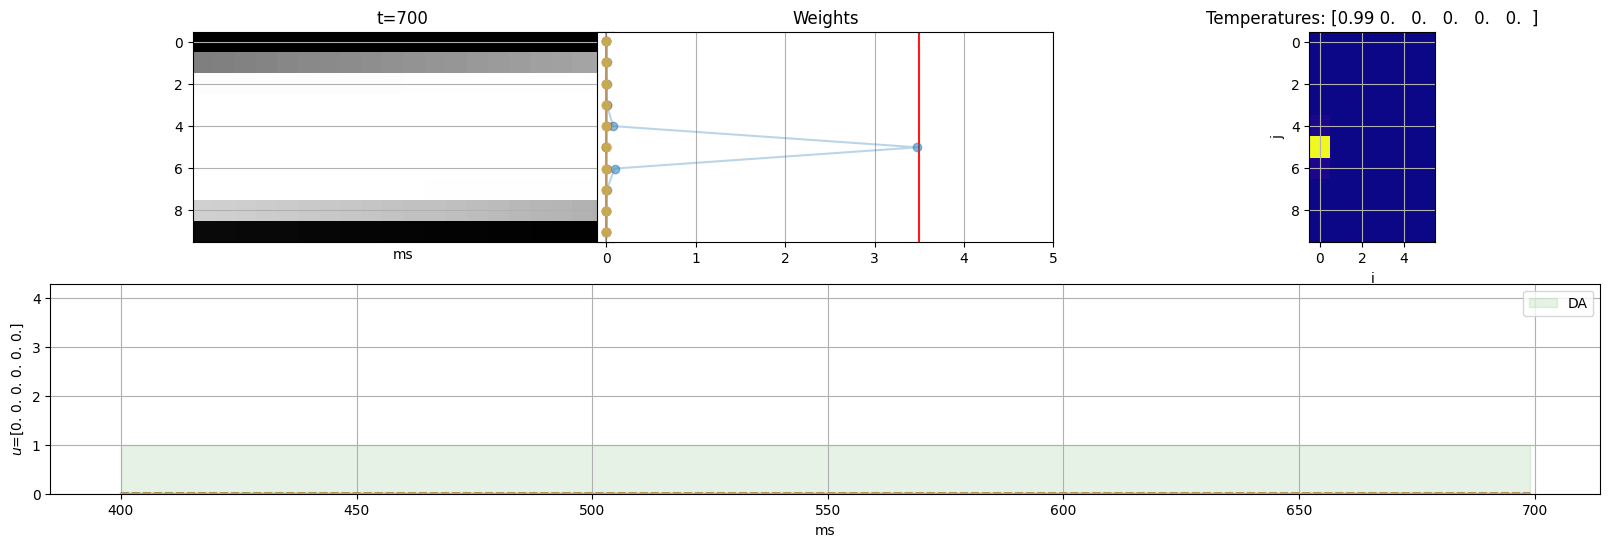

 q


In [501]:
model.reset()

record = np.zeros((N+1, len(X)))
Ix = np.zeros((N, len(X)))
X2 = np.zeros((len(X) + 10, Nj))

colors = [plt.cm.tab20(i/N) for i in range(N)]

for t, x in enumerate(X):
    try:
        model.step(x=x.reshape(-1, 1))
        record[1:, t] = model.u.flatten()
        record[0, t] = model.DA
        Ix[:, t] = model.Ix.flatten()
        
        X2[10:t+10] = X[:t]
    
        if t % 100 == 0:
            mv.plotting(model=model, X=X2, t=t, record=record, Ix=Ix, colors=colors)
            
    except KeyboardInterrupt:
        print('[paused]')
        clf()
        mv.plotting(model=model, X=X2, t=t, record=record, Ix=Ix, colors=colors)
        plt.show()
        while True:
            try:
                response = input()
                if response in ('quit', 'q', 'qq', 'c', ' '):
                    break
                print('[resume]')
                plt.show()
            except KeyboardInterrupt:
                print('[resuming...]')
                continue
        if response in ('quit', 'q', 'qq'):
            break

## Simulation III - *model 3*
---

#### Load individual

In [1239]:
file = me.load_best_individual()
info, genome = file['info'], file['genome']

2023-11-30 18:42:33 | Available files in /Users/daniekru/Research/lab/PCNN/cache:
2023-11-30 18:42:33 | 0: best_16.json
2023-11-30 18:42:33 | 1: top_2311.json
2023-11-30 18:42:33 | 2: best_3011_1756.json
2023-11-30 18:42:33 | 3: best_3011_1604.json
2023-11-30 18:42:33 | 4: best_17.json
2023-11-30 18:42:33 | 5: top_2238.json
2023-11-30 18:42:33 | 6: top_ij_1.json
2023-11-30 18:42:33 | 7: best_3011_1527.json
2023-11-30 18:42:33 | 8: best_3011_1545.json
2023-11-30 18:42:33 | 9: top_2239_r3.json
2023-11-30 18:42:33 | 10: best_3011_1641.json
2023-11-30 18:42:33 | 11: best_3011_1753.json
2023-11-30 18:42:33 | 12: best_3011_1552.json
2023-11-30 18:42:33 | 13: best_14.json
2023-11-30 18:42:33 | 14: best_3011_1554.json
2023-11-30 18:42:33 | 15: best_15.json
2023-11-30 18:42:33 | 16: best_3011_1558.json


Choose a file:  4


2023-11-30 18:42:40 | Best individual loaded from best_17.json in /Users/daniekru/Research/lab/PCNN/cache.


In [1240]:
print('Info')
pprint(info)
print('\nGenome')
pprint(genome)

model = mm.RateNetwork3(**genome)
logger.info(model)

2023-11-30 18:42:45 | RateNetwork3(N=15, Nj=6, rule=hebb) [Xm1Lj]


Info
{'date': '30/11/2023 at 18:37',
 'game': 'Track2D(fitness_size=2)',
 'model': 'RateNetwork3'}

Genome
{'N': 15,
 'Nj': 6,
 'bias': 3.0,
 'dt': 0.013,
 'gain': 9.0,
 'lr': 0.90598,
 'rule': 'hebb',
 'soft_beta': 57.4,
 'std_tuning': 0.0085,
 'tau': 18,
 'wff_max': 7.1,
 'wff_min': 0.0,
 'wff_std': 0.001,
 'wff_tau': 927}


**Tweak the model**

In [1243]:
genome['N'] = 15
genome['Nj'] = 10

model = mm.RateNetwork3(**genome)
logger.info(model)

2023-11-30 18:43:02 | RateNetwork3(N=15, Nj=10, rule=hebb) [UAGak]


#### Settings

2023-11-30 18:43:03 | InputLayer(N=10, kind=hd, sigma=1)


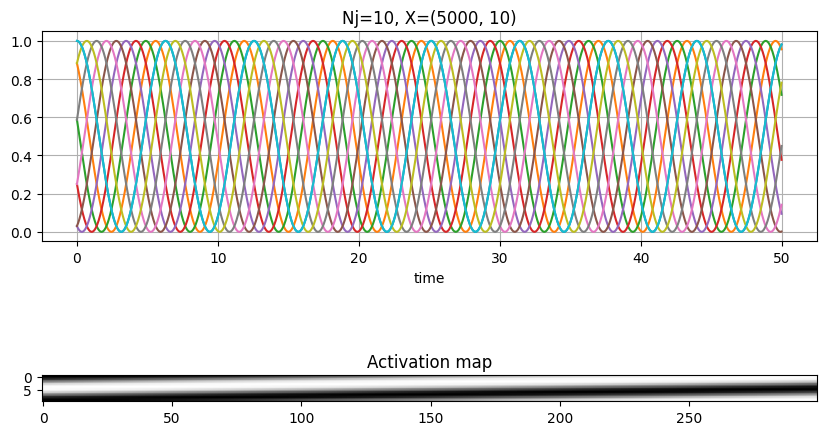

In [1244]:
N = model.N
Nj = model.Nj

# data
layer = it.InputLayer(N=Nj, kind='hd', sigma=1, max_rate=1)
logger.info(layer)

# input
X = layer.parse_trajectory(np.arange(0, 50, 0.01))
T = len(X)

# plot
plot_x(X)

#### Training

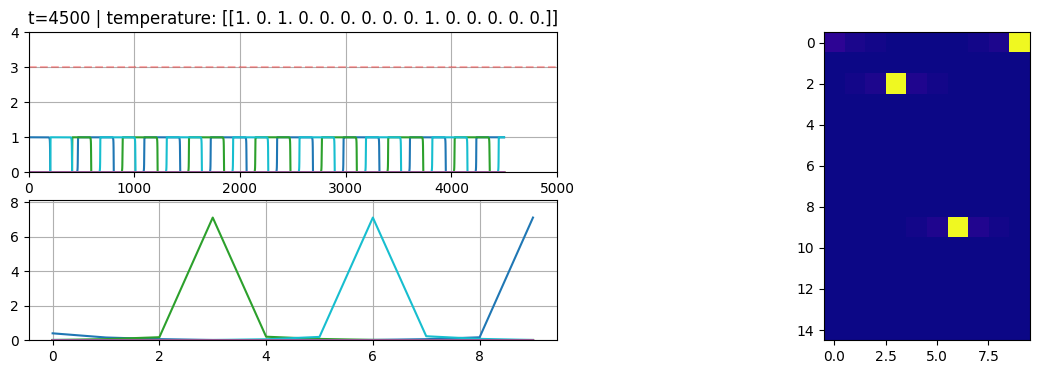

In [1245]:
model.reset()

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    model.step(x=x.reshape(-1, 1))

    # record
    record[t] = model.u.flatten()

    if t % 500 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(221)
        plt.axhline(model._bias, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, model._bias+1))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=} | temperature: {np.around(model.temp.T, 3)}")
        
        plt.subplot(223)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), model.Wff[i])

        plt.ylim((0, model._wff_max+1))
        plt.grid()

        plt.subplot(122)
        plt.imshow(model.Wff, cmap='plasma')
        plt.pause(0.0001)

## Simulation IV - *performance search*
---

#### Training - *Model 6*

**New genome**

In [502]:
N = 10
Nj = 7

genome = {'gain': 30.0,
 'bias': 2.5,
 'lr': 0.1,
 'tau': 40,
 'wff_std': 0.001,
 'wff_min': 0.0,
 'wff_max': 3.5,
 'wff_tau': 950,
 'rule': 'hebb',
 'std_tuning': 0.001,
 'soft_beta': 40,
 'dt': 0.00035,
 'N': N,
 'Nj': Nj,
 'DA_tau': 3,
 'bias_scale': 0.055,
 'bias_decay': 75,
}

**Settings**

2023-12-11 15:03:10 | RateNetwork4(N=10, Nj=7, rule=hebb) [AJo8W]


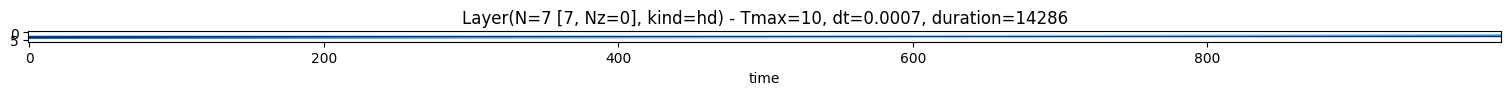

In [503]:
# model
model = mm.RateNetwork6(**genome)
logger.info(model)

N = genome['N']
Nj = genome['Nj']

# input
Tmax = 10
dt = 0.0007
layer = it.HDLayer(N=Nj, sigma=0.015)
trajectory = np.arange(0, Tmax, dt)
duration = len(trajectory)
X = layer.parse_trajectory(trajectory=trajectory)
plt.figure(figsize=(19, 4))
plt.imshow(X[:1000].T, cmap='Blues')
plt.xlabel('time')
plt.title(f"{layer} - {Tmax=}, {dt=}, {duration=}")
plt.show()


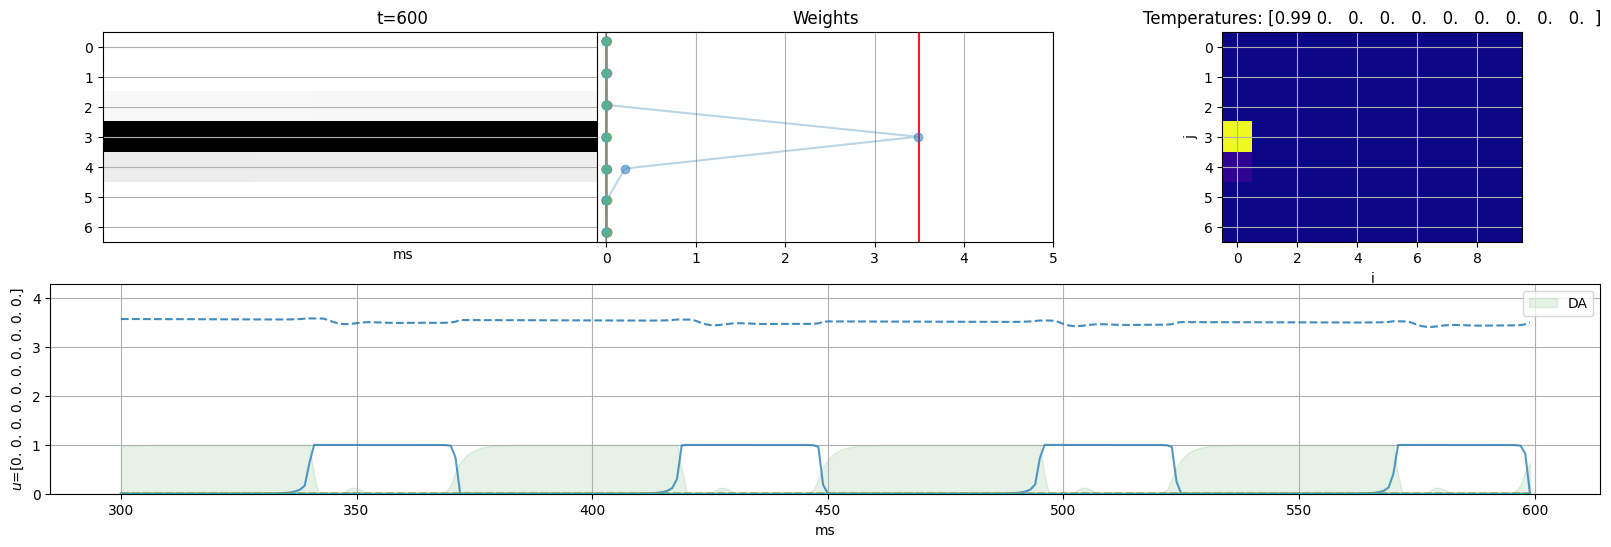

In [506]:
model.reset()

record = np.zeros((N+1, len(X)))
Ix = np.zeros((N, len(X)))
X2 = np.zeros((len(X) + 10, Nj))

colors = [plt.cm.tab20(i/N) for i in range(N)]

for t, x in enumerate(X):
    try:
        model.step(x=x.reshape(-1, 1))
        record[1:, t] = model.u.flatten()
        record[0, t] = model.DA
        Ix[:, t] = model.Ix.flatten()
        
        X2[10:t+10] = X[:t]
    
        if t % 100 == 0:
            mv.plotting(model=model, X=X2, t=t, record=record, Ix=Ix, colors=colors)
            
    except KeyboardInterrupt:
        print('[paused]')
        clf()
        mv.plotting(model=model, X=X2, t=t, record=record, Ix=Ix, colors=colors)
        plt.show()
        while True:
            try:
                break
                response = input()
                if response in ('quit', 'q', 'qq', 'c', ' '):
                    break
                print('[resume]')
                plt.show()
            except KeyboardInterrupt:
                print('[resuming...]')
                continue
        if response in ('quit', 'q', 'qq'):
            break

#### Performance search

##### close look at the evaluation function

In [543]:
axis=0
ni, nj = model.Wff.shape
print('ni nj ', ni, nj)
w = np.where(model.Wff>3, 1, 0).sum(axis=axis)
print('w ', w)
nb_empty = 1*((axis==0)*(nj>ni)*(nj - ni) + (axis==1)*(nj<ni)*(ni - nj))
print('legit empty ', nb_empty)

e_over = w[w > 1] -1

print('over ', e_over)
nb_under = (w < 1).sum() - nb_empty
print('under ', nb_under)
#err = abs(e_over.sum() - nb_under)
err = nb_under + ((e_over.sum() - nb_under) > 0)*(e_over.sum() - nb_under) 
print('err ', err)
print('sum ', np.where(w != 1, 1, 0))
score = (err.sum() - 0*nb_empty)/ni 
print('score ', score)
np.where(w != 1, 1, 0).sum()

ni nj  40 40
w  [1 0 0 0 1 0 0 0 1 0 1 4 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1
 0 0 1]
legit empty  0
over  [3]
under  26
err  26
sum  [0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0
 1 1 0]
score  0.65


27

##### Run 
*evaluating the model with different input and network sizes*

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28572/28572 [00:00<00:00, 29777.02it/s]


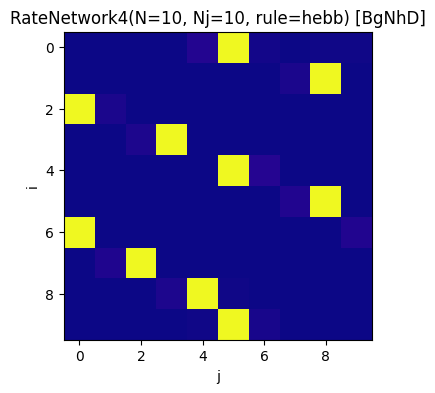

2023-12-12 12:20:17 | #i for j: 0.60
2023-12-12 12:20:17 | #i for j: 0.60
2023-12-12 12:20:17 | #i for j: 0.60
2023-12-12 12:20:17 | #i for j: 0.60
2023-12-12 12:20:17 | #j for i: 1.00
2023-12-12 12:20:17 | #j for i: 1.00
2023-12-12 12:20:17 | #j for i: 1.00
2023-12-12 12:20:17 | #j for i: 1.00


In [412]:
genome = {'gain': 30.0,
 'bias': 2.5,
 'lr': 0.1,
 'tau': 40,
 'wff_std': 0.01,
 'wff_min': 0.0,
 'wff_max': 3.5,
 'wff_tau': 950,
 'rule': 'hebb',
 'std_tuning': 0.1,
 'soft_beta': 40,
 'dt': 0.00035,
 'N': N,
 'Nj': Nj,
 'DA_tau': 3,
 'bias_scale': 0.055,
 'bias_decay': 75,
}

nb = 2
model, record = mm.train_model(genome=genome, 
                         N=10, Nj=10,
                         Tmax=20, dt=0.0007, sigma=0.019, nb=nb, display=True)

# plot
if 1:
    plt.figure(figsize=(4, 4))
    plt.imshow(model.Wff, cmap='plasma')
    plt.title(f"{model}")
    plt.xlabel('j')
    plt.ylabel('i')
    plt.show()

logger.info(f"#i for j: {record[0].mean():.2f}")
logger.info(f"#j for i: {record[1].mean():.2f}")

#### Grid search

In [531]:
def grid_eval(genome, Nlist, Njlist, Tmax=10, dt=0.0007, sigma=0.015, nb=1):

    """
    Evaluation of a list of N, Nj values
    """

    table_1 = []
    table_2 = []

    for n, nj in tqdm(zip(Nlist, Njlist)):
        model, record = train(genome=genome, N=n, Nj=nj, 
                                       Tmax=Tmax, dt=dt, sigma=sigma, nb=nb)
        table_1 += [record[0].std(axis=1).mean()/nb]
        table_2 += [record[1].std(axis=1).mean()/nb]

    return table_1, table_2

def grid_search(genome, Nlist, Njlist, Tmax=10, dt=0.0007, sigma=0.015, nb=1, func=None):

    """
    Grid search over a list of N, Nj values
    """

    table_1 = np.zeros((len(Nlist), len(Njlist)))
    table_2 = np.zeros((len(Nlist), len(Njlist)))

    if func is None:
        func = lambda x: x.std(axis=1).mean()

    for i, n in tqdm_enumerate(Nlist):
        for j, nj in enumerate(Njlist):
            model, record = train(genome=genome, N=n, Nj=nj, 
                                           Tmax=Tmax, dt=dt, sigma=sigma, nb=nb)
            table_1[i, j] = func(model, axis=0)
            table_2[i, j] = func(model, axis=1)

    return table_1, table_2

**Grid search simulation**

2023-12-07 16:13:59 | iter=100 nb=3
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [32:33<00:00, 195.39s/it]


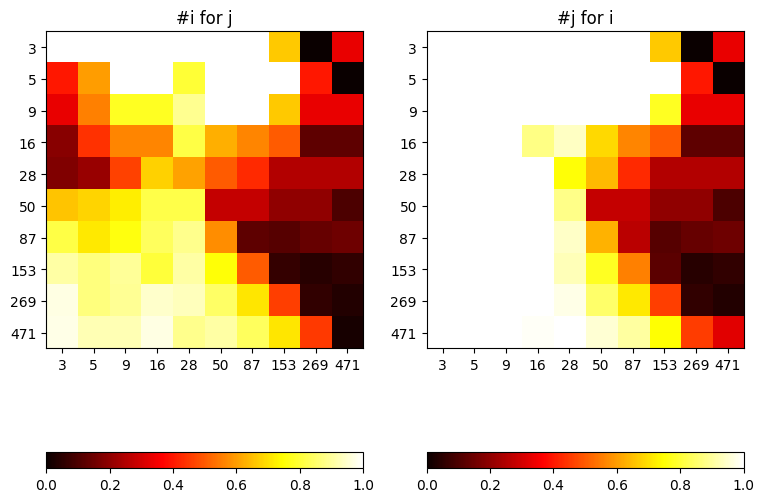

In [694]:
""" list of N, Nj values """
Nlist = np.logspace(2, 11, num=10, base=1.75, endpoint=True).astype(int)
Njlist = np.logspace(2, 11, num=10, base=1.75, endpoint=True).astype(int)
ratio = np.around(Nlist / Njlist * Nlist, 2)

nb = 3

# run
logger.info(f"iter={len(Nlist)**2} {nb=}")
tb1, tb2 = grid_search(genome=genome, Nlist=Nlist, Njlist=Njlist, Tmax=20, dt=0.0007, sigma=0.015, nb=nb, func=eval_func)

""" Heatmap plot """

plt.figure(figsize=(9, 9))
plt.subplot(121)
plt.imshow(tb1, cmap='hot')
plt.title("#i for j")
plt.colorbar(location='bottom')
plt.xticks(range(len(Nlist)), Njlist)
plt.yticks(range(len(Nlist)), Nlist)

plt.subplot(122)
plt.imshow(tb2, cmap='hot')
plt.title("#j for i")
plt.colorbar(location='bottom')
plt.xticks(range(len(Nlist)), Njlist)
plt.yticks(range(len(Nlist)), Nlist)
plt.show()

**Line plot**

2023-12-07 11:46:10 | iter=10


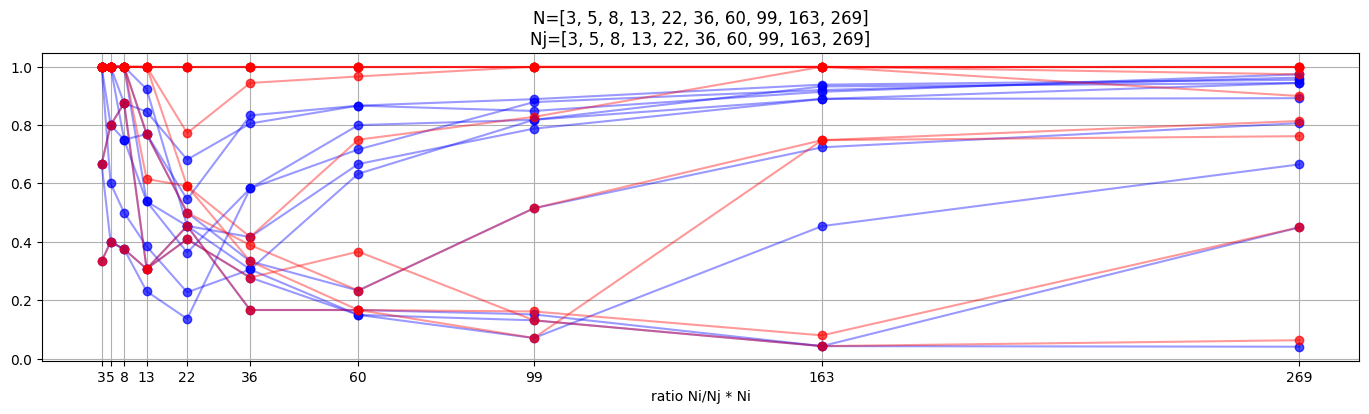

In [535]:
plt.figure(figsize=(17, 4))
plt.plot(ratio, tb1, '-b', alpha=0.4, label="#i for j")
plt.plot(ratio, tb2, '-r', alpha=0.4, label="#j for i")
plt.plot(ratio, tb1, 'ob', alpha=0.7)
plt.plot(ratio, tb2, 'or', alpha=0.7)
plt.grid()
plt.title(f"N={Nlist.tolist()}\nNj={Njlist.tolist()}")
plt.xticks(ratio)
plt.xlabel("ratio Ni/Nj * Ni")
#plt.legend()
plt.show()

## Simulation V - *oscillatory stimulation 2.0*
---

#### Oscillatory stimulation 
Study of how to organize the tuning of the neuron to the background stimulation in a such a way that the distance between two adjacent tunings is constant.

tot:     10
n/cycle: 5
distance between tuning: 1.0112


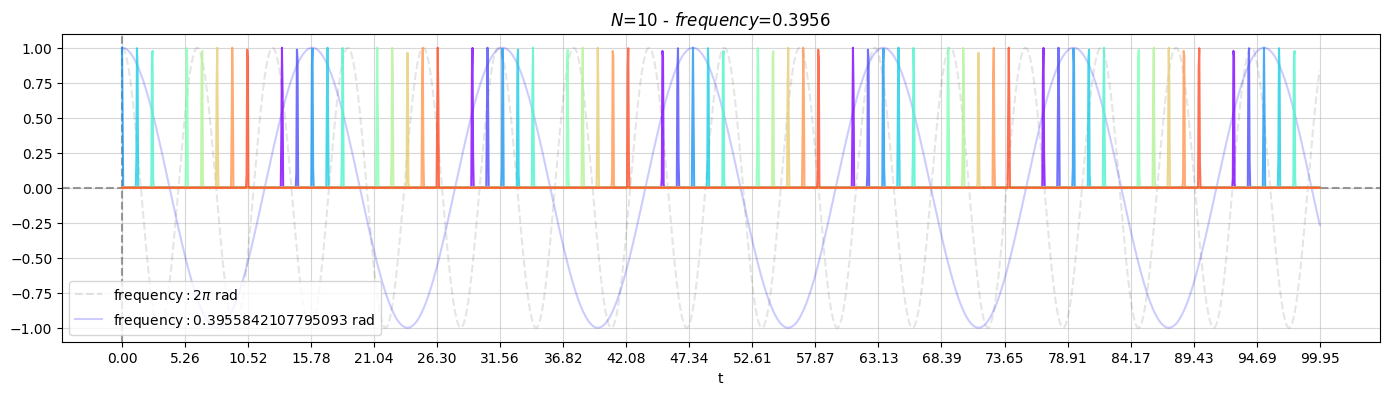

In [557]:
""" oscillatory function """
base = lambda t, b: np.cos(b*t)
#f = lambda t, o, b: (1*(np.cos(b*t)>0))*np.exp(-(np.cos(b*2*(t - o))-1.)**2/(b**2.5/1e5))
f = lambda t, o, b: (1*(np.cos(b*t)>0))*np.exp(-(np.cos(b*2*(t - o))-1.)**2/(b**2.5/1e5))

g = lambda t, o, b: (1*(np.cos(b*t)<0))*np.exp(-(np.cos(b*2*(t - o))-1.)**2/(b**2.5/1e5))
b_curve_fit = lambda x, a, b, c: a*np.exp(-b*x)+c


""" settings """
X = np.arange(0, 100, 0.05)
N = 10
n = N//2

### choice of <b>
b = b_curve_fit(N, 0.85, 0.09, 0.05)
#b = 0.05

Yb = base(X, b)
Yr = np.cos(X)
Ys = [f(X, o, b) for o in np.linspace(-1/b, 1/b, n, endpoint=True)]
Ys2 = [g(X, o, b) for o in np.linspace(-1/b, 1/b, n, endpoint=True)]

print(f"tot:     {N}\nn/cycle: {n}\ndistance between tuning: {2/b/n:.4f}")

""" plotting """
colors = [plt.cm.rainbow(i/N) for i in range(N)]

plt.figure(figsize=(17, 4))
plt.title(f"$N$={N} - $frequency$={b:.4f}")
plt.axhline(0, color='gray', linestyle='--', alpha=.8) 
plt.axvline(0, color='gray', linestyle='--', alpha=.8) 
plt.plot(X, Yr, '--', color='black', alpha=.1, label="frequency$:2\pi$ rad")
plt.plot(X, Yb, '-b', alpha=0.2, label=f"frequency$:{b:.3f}$ rad")
for i in range(n):
    plt.plot(X, Ys[i], '-', color=colors[i], alpha=0.8)
    
for i in range(n):
    plt.plot(X, Ys2[i], '-', color=colors[i+n], alpha=0.8)
    
plt.grid(alpha=0.5)
plt.xticks(np.linspace(0, X.max(), 20).tolist())
plt.legend()
plt.xlabel("t")
plt.show()

#### Tuning of the frequency 1
Since the number of neurons $N$ affects the distribution of the tuning curves (e.g. the tuning frequency of each neuron), it is necessary to obtain a good estimate of the relationship between $N$ and the frequency parameter $b$, which appears in both the base oscillation and the neuron tuning.

**Manual data**

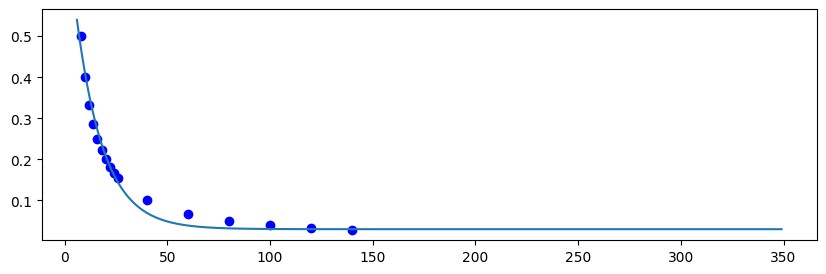

In [2]:
# datapoints obtained manually
manual_bdata = np.array([[8, 0.5], [10, 0.4], [12, 0.3333], [14, 0.2857], [16, 0.25], [18, 0.2222], [20, 0.2], [22, 0.181818], [24, 0.1666], [26, 0.153846], 
              [40, 0.1], [60, 0.06667], [80, 0.05], [100, 0.04], [120, 0.0333], [140, 0.028571]])

plt.figure(figsize=(10, 3))
plt.plot(manual_bdata[:, 0], manual_bdata[:, 1], 'ob')
xx = np.array(range(6, 350))
plt.plot(xx, b_curve_fit(xx, 0.8, 0.075, 0.03))
plt.show()

**Gradient Descent fitting**

Assuming the model is an exponential of the form $a\,e^{-b} + c$

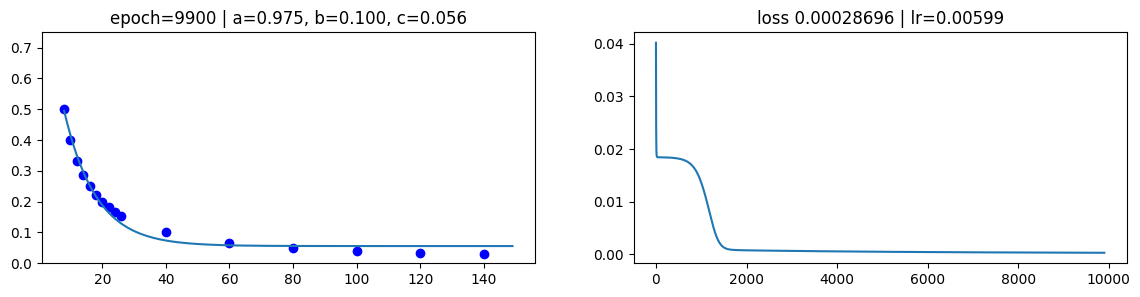

2023-12-06 14:50:40 | GD fitted parameters: a=0.97, b=0.10, c=0.06


In [8]:
def GD_fit(data, lr=0.01, epochs=10_000):

    a, b, c = 1, 1, 0.03

    xx = np.array(range(8, 150))
    loss = []
    for epoch in range(epochs):
        L0 = 10
        ltot = 0
        for xy in data:
            x, y = xy
            out = a*np.exp(-b*x)+c
            L = y - out
            ga = L * np.exp(-b*x)
            gb = -L * 1/x
            gc = L
            a += lr * ga
            b += lr * gb
            c += lr * gc
    
            ltot += (y-out)**2
    
        loss += [ltot/len(data)]
        if len(loss) > 100:
            if loss[-100] < loss[-1]:
                logger.debug("stoploss")
                break
    
        if epoch % 1000 == 0:
            lr *= 0.95
    
        if epoch % 100 == 0:
            clf()
            plt.figure(figsize=(14, 3))
            plt.subplot(121)
            plt.plot(data[:, 0], data[:, 1], 'ob')
            plt.plot(xx, a*np.exp(-b*xx)+c)
            plt.title(f"{epoch=} | {a=:.3f}, {b=:.3f}, {c=:.3f}")
            plt.ylim((0, 0.75))
    
            plt.subplot(122)
            plt.plot(range(0, epoch+1), loss)
            plt.title(f"loss {loss[-1]:.8f} | {lr=:.5f}")
            plt.pause(0.001)

    return a, b, c

a, b, c = GD_fit(data=manual_bdata, lr=1e-2, epochs=10_000)
logger.info(f"GD fitted parameters: {a=:.2f}, {b=:.2f}, {c=:.2f}")

**Iterative search of the correct $b$ given a value of $N$**

The heuristic used is a simplification of Newton's method. The goal is to find a value of $b$ whose error wrt a target value is less than a given $\epsilon$. The estimate of $b$ is based on the error direction and size of the previous stepsize.

In [15]:
# system on which apply the settings
base = lambda t, b: np.cos(b*t)
X = np.arange(0, 50, 0.01)
f = lambda t, o, b: (1*(np.cos(b*t)>0))*np.exp(-(np.cos(b*2*(t - o))-1.)**2/(b**2.5/1e5))
g = lambda t, o, b: (1*(np.cos(b*t)<0))*np.exp(-(np.cos(b*2*(t - o))-1.)**2/(b**2.5/1e5))


def try_b(N, b):
    """ evaluate a value of b given an N """
    n = N//2
    Yb = base(X, b)
    Yr = np.cos(X)
    Ys = [f(X, o, b) for o in np.linspace(-1/b, 1/b, n, endpoint=True)]
    Ys2 = [g(X, o, b) for o in np.linspace(-1/b, 1/b, n, endpoint=True)]

    return 2/b/n

def calc_b(N, b0, eps=0.0001, trg=1, max_time=500):
    """ heuristic """
    
    b = b0
    err = 10
    err0 = 10
    step = 0.01
    t = 0
    while abs(err) > eps:

        # run for a value of b
        val = try_b(N=N, b=b)

        # error
        err = trg - val

        # evaluate error against epsilon
        if abs(err) < eps:
            break

        # calc stepsize: decrease it if the error is less than before
        if err < err0:
            step *= 0.99
        err0 = err

        # new b
        if err > 0:
            b -= step
        else:
            b += step 

        t += 1
        if t == max_time: # upper limit 
            #print('!too much')
            break

    return b, val

b_est, distance = calc_b(N=8, b0=0.6, eps=1e-4)
logger.info(f"Estimated b={b_est:.3f}, {distance=:.3f}")

2023-12-06 15:01:48 | Estimated b=0.500, distance=1.000


$b$ estimation and comparison with the manually found values

In [19]:
for N, y in manual_bdata:
    N = int(N)
    p, v = calc_b(N=N, b0=0.6)
    print(f"\nN={N:.0f}\n   {y=:.4f}\n   {p=:.4f} ({v:.3f})")


N=8
   y=0.5000
   p=0.5000 (1.000)

N=10
   y=0.4000
   p=0.4000 (1.000)

N=12
   y=0.3333
   p=0.3333 (1.000)

N=14
   y=0.2857
   p=0.2857 (1.000)

N=16
   y=0.2500
   p=0.2500 (1.000)

N=18
   y=0.2222
   p=0.2222 (1.000)

N=20
   y=0.2000
   p=0.2000 (1.000)

N=22
   y=0.1818
   p=0.1818 (1.000)

N=24
   y=0.1666
   p=0.1667 (1.000)

N=26
   y=0.1538
   p=0.1539 (1.000)

N=40
   y=0.1000
   p=0.0999 (0.995)

N=60
   y=0.0667
   p=0.0672 (1.001)

N=80
   y=0.0500
   p=0.0500 (1.000)

N=100
   y=0.0400
   p=0.0404 (1.003)

N=120
   y=0.0333
   p=0.0333 (0.985)

N=140
   y=0.0286
   p=0.0286 (1.000)


**Make dataset of $(N, b)$ pairs using the heuristic method**

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [04:32<00:00,  3.40s/it]
2023-12-06 15:14:26 | (80, 3)


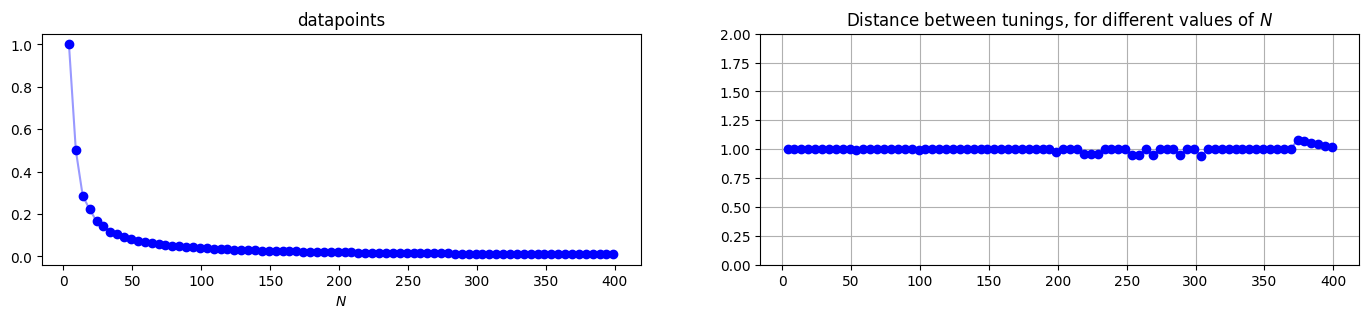

In [29]:
heuristic_bdata = []
b0 = 0.5
for n in tqdm(range(4, 400, 5)):
    p, v = calc_b(N=n, b0=b0, eps=1e-3)
    heuristic_bdata += [[n, p, v]]
    b0 *= 0.7

heuristic_bdata = np.array(heuristic_bdata)
logger.info(heuristic_bdata.shape)

plt.figure(figsize=(17, 3))
plt.subplot(121)
plt.plot(heuristic_bdata[:, 0], heuristic_bdata[:, 1], '-b', alpha=0.4)
plt.plot(heuristic_bdata[:, 0], heuristic_bdata[:, 1], 'ob')
plt.title("datapoints")
plt.xlabel("$N$")

plt.subplot(122)
plt.plot(heuristic_bdata[:, 0], heuristic_bdata[:, 2], '-b', alpha=0.5)
plt.plot(heuristic_bdata[:, 0], heuristic_bdata[:, 2], 'ob')
plt.title("Distance between tunings, for different values of $N$")
plt.ylim((0, 2))
plt.grid()
plt.show()

#### Tuning of the frequency 2

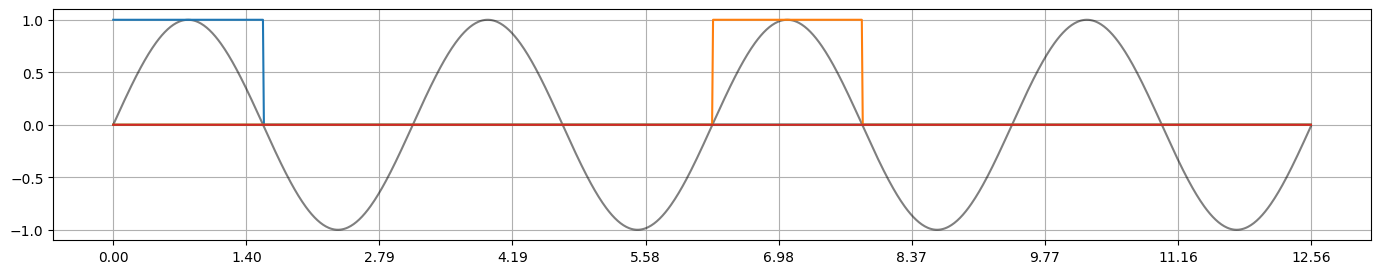

In [370]:
def calc_turn_old(N, t, i=0, K=6, fscale=1):
    """ function tat calculates when a certain cycle of neurons should be active """
    r = K / N

    offset = i // K
    above = t % (2/fscale * 2 * np.pi) < (offset+1)*(r * 2/fscale * 2 * np.pi)
    below = (offset)*(r * 2 / fscale * 2 * np.pi) <= t % (2/fscale * 2 * np.pi)
    return 1*(above * below)

def calc_turn(N, t, i=0, K=6, b=1, nb_skip=1):
    """ function tat calculates when a certain cycle of neurons should be active """

    cycle_size = np.pi / b  # size of a cycle in rad
    nb_cycles = np.ceil(N / K) * nb_skip  # total number of cycles
    tot_cycle_len = cycle_size * nb_cycles  # total length of the grand cycle
    t = t % tot_cycle_len  # map t onto the grand cycle 
    curr_idx = t // cycle_size  # calc the current cycle idx
    i = (i) // (K) * nb_skip  # idx of the cycle the input belongs to
    return 1*(curr_idx == i)

def calc_tuning(N, K, b):
    """ calculate the tuning of the neurons """
    partitions = np.linspace(-np.pi/2/b+1*np.pi/2/b/K, np.pi/2/b+1*np.pi/2/b/K, K, endpoint=0)
    return np.array([partitions[i%K] for i in range(0, N)]).reshape(-1, 1)

def calc_gamma(t, O, b, s=1e-5):
    """ calculate the activity as gamma cycles """
    t = t % (2*np.pi / b) 
    return np.exp(-(np.sin(b*(t - O))-1)**2 / s)
    
def calc_osc(N, t, I, O, K, b, nb_skip=1, s=1e-5):
    """ calculate the oscillatory stimulation """
    return calc_turn(N=N, t=t, i=I, K=K, b=b, nb_skip=nb_skip) * calc_gamma(t=t, O=O, b=b, s=s)


X = np.arange(0, 4*np.pi, 0.01)
b = 2
nb_skip = 4

plt.figure(figsize=(17, 3))
plt.plot(X, np.sin(fscale*X), '-k', alpha=0.5)
plt.plot(X, calc_turn(N=12, t=X, i=1, K=3, b=b, nb_skip=nb_skip))  # 4 8 12 16
plt.plot(X, calc_turn(N=12, t=X, i=5, K=3, b=b, nb_skip=nb_skip))  # 4 8 12 16
plt.plot(X, calc_turn(N=12, t=X, i=8, K=3, b=b, nb_skip=nb_skip))  # 4 8 12 16
plt.plot(X, calc_turn(N=12, t=X, i=10, K=3, b=b, nb_skip=nb_skip))  # 4 8 12 16

plt.xticks(np.linspace(0, X.max(), 10))
plt.grid()
plt.show()

##### Oscillatory stimulation

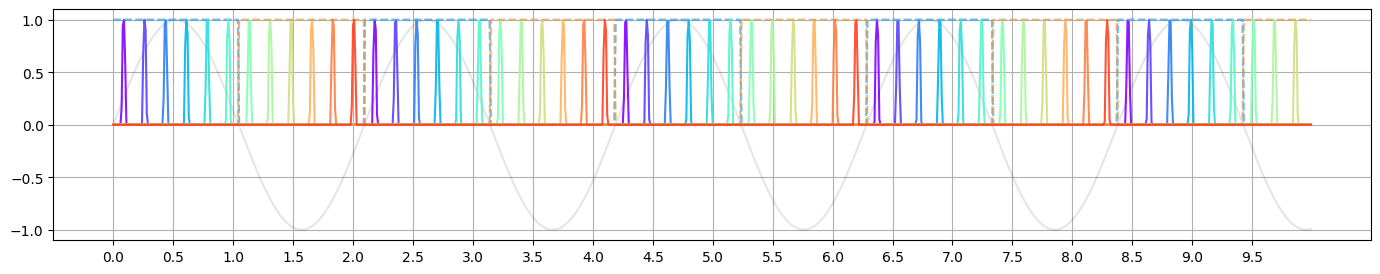

In [247]:
N = 12
I = np.arange(N).reshape(-1, 1)
K = 6
b = 3
O = mm.calc_tuning(N, K, b)
X = np.arange(0, 10, 0.01) 

nb_skip = 1

#logger.info(f"{np.around(O.T, 3)}")
def calc_gamma(t, O, b, s=1e-5):
    """ calculate the activity as gamma cycles """
    t = t % (np.pi / b) 
    return np.exp(-(np.sin(b*(t - O))-1)**2 / s)
 
Y = mm.calc_osc(N=N, t=X, I=I, O=O, K=K, b=b, nb_skip=nb_skip)
Y2 = mm.calc_turn(N=N, t=X, i=I, K=K, b=b, nb_skip=nb_skip)
Y3 = mm.calc_gamma(t=X, O=O, b=b)

plt.figure(figsize=(17, 3))
#plt.plot(X, np.sin(b*(X % (np.pi/b))), '-k', alpha=0.1)
plt.plot(X, np.sin(b*X), '-k', alpha=0.1)

colors = [plt.cm.rainbow(j/N) for j in range(N)]
for i in range(N):
    plt.plot(X, Y[i], '-', color=colors[i], alpha=0.9)
    plt.plot(X, Y2[i], '--', color=colors[i], alpha=0.2)
    #plt.plot(X, Y3[i], '-', color=colors[i], alpha=0.8)

   
plt.xticks(np.arange(0, X.max(), .5))
plt.grid()
plt.show()

## Simulation VI - *model 7*
---

#### Theta calibration

##### Utils

In [232]:
def plotting_vi():
    clf()
    plt.figure(figsize=(20, 7))
    
    plt.subplot(211)
    plt.title(f"{t}ms [{T}] - {dt=}ms - {N=}")
    for i in range(N):
        plt.plot(period[max((ti-tsize, 0)):ti], record[i, max((ti-tsize, 0)):ti], 'o', color=colors[i], alpha=0.9)
        plt.plot(period[max((ti-tsize, 0)):ti], record[i, max((ti-tsize, 0)):ti], '-', color=colors[i], alpha=0.5)
    plt.grid()
    plt.xticks(np.linspace(max((t-tsize*dt, 0)), t, 10))
    plt.ylim((0, 6.1))

    plt.subplot(212)
    plt.imshow(inputs[int(max((ti-tsize*dt, 0))): ti].T, cmap='Blues')
    plt.xticks(np.linspace(0, tsize*dt, 10), np.around(np.linspace(max((t-tsize*dt, 0)), t, 10)))
    plt.xlabel('time')
    plt.title(f"{layer} - {speed*(1000/dt):.2f}m/s")
    plt.pause(0.2)

##### Run

KeyboardInterrupt: 

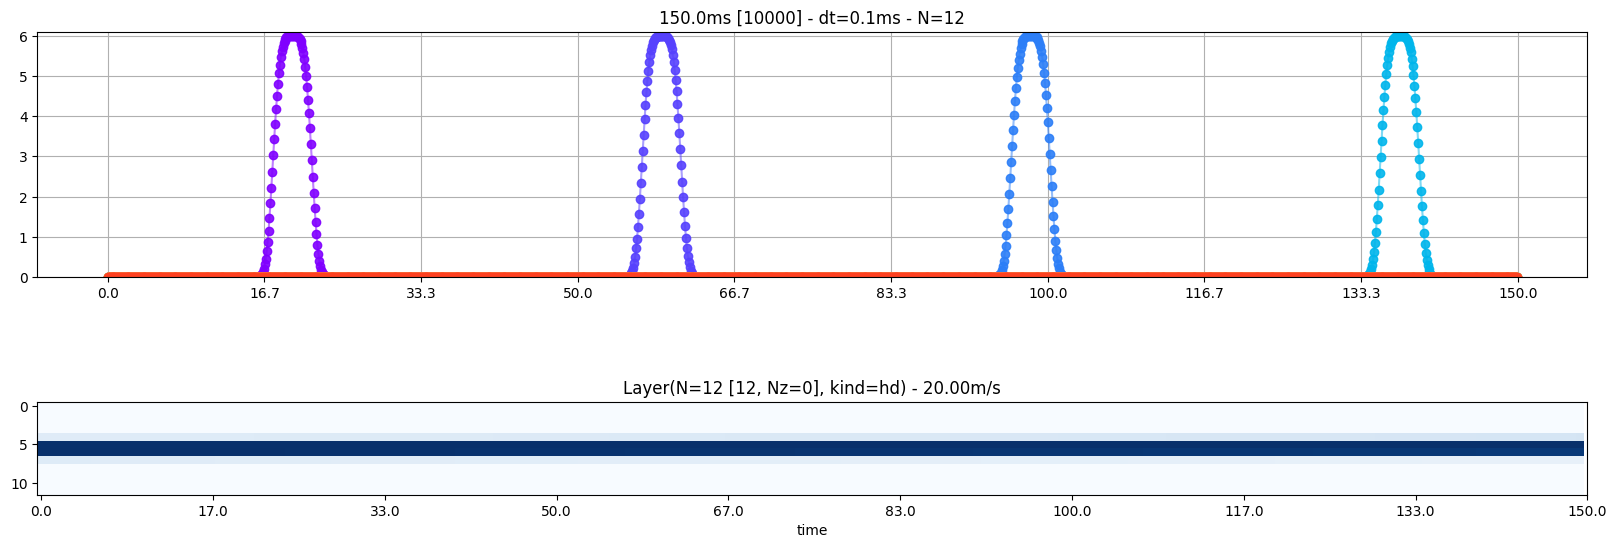

In [266]:
N = 12
Nj = 12

genome = {
    'gain': 30.0,
          'bias': 2.5,
          'lr': 0.5,
          'tau': 4,
          'wff_std': 0.001,
          'wff_min': 0.0,
          'wff_max': 3.5,
          'wff_tau': 950,
          'std_tuning': 0.001,
          'soft_beta': 40,
          'dt': 1,
          'N': N,
          'Nj': Nj,
          'DA_tau': 3,
          'bias_scale': 0.055,
          'bias_decay': 75,
          'IS_magnitude': 6,
          'theta_freq': 0.002,
          'nb_per_cycle': 4,
          'plastic': False,
          'nb_skip': 1,
}

# model
model = mm.RateNetwork7(**genome)

# settings
T = 10*1000 # s
dt = 0.1 # ms
period = np.arange(0, T, dt)

# inputs
speed = 0.002 # 0.001
layer = it.HDLayer(N=Nj, sigma=0.01)
inputs = layer.parse_trajectory(trajectory=np.linspace(0, T*speed, len(period)))

# plot
tsize = int(200/dt)
colors = [plt.cm.rainbow(i/N) for i in range(N)]
record = np.zeros((N, len(period)))

# simulation
for ti, t in enumerate(period):
    model.step()
    record[:, ti] = model.Is.flatten()

    if ti % 100 == 0:
        plotting_vi()

    if t == 1000:
        break

logger()

#### Training - *online visualization*

In [991]:
# input
whole_track = it.AnimalTrajectory.whole_walk(dx=0.01)

# Create an animal
animal = it.AnimalTrajectory(dt=0.02, 
                             prob_turn=0.1, 
                             prob_speed=0.0,
                             prob_rest=0.0, 
                             day_cycle=False)

# Create a trajectory
trajectory_pc = animal.make_trajectory(duration=40000, whole=False, dx=1, normalize=0, turning_scale=1, speed=1)

inputs_pc = layer_pc.parse_trajectory(trajectory=trajectory)

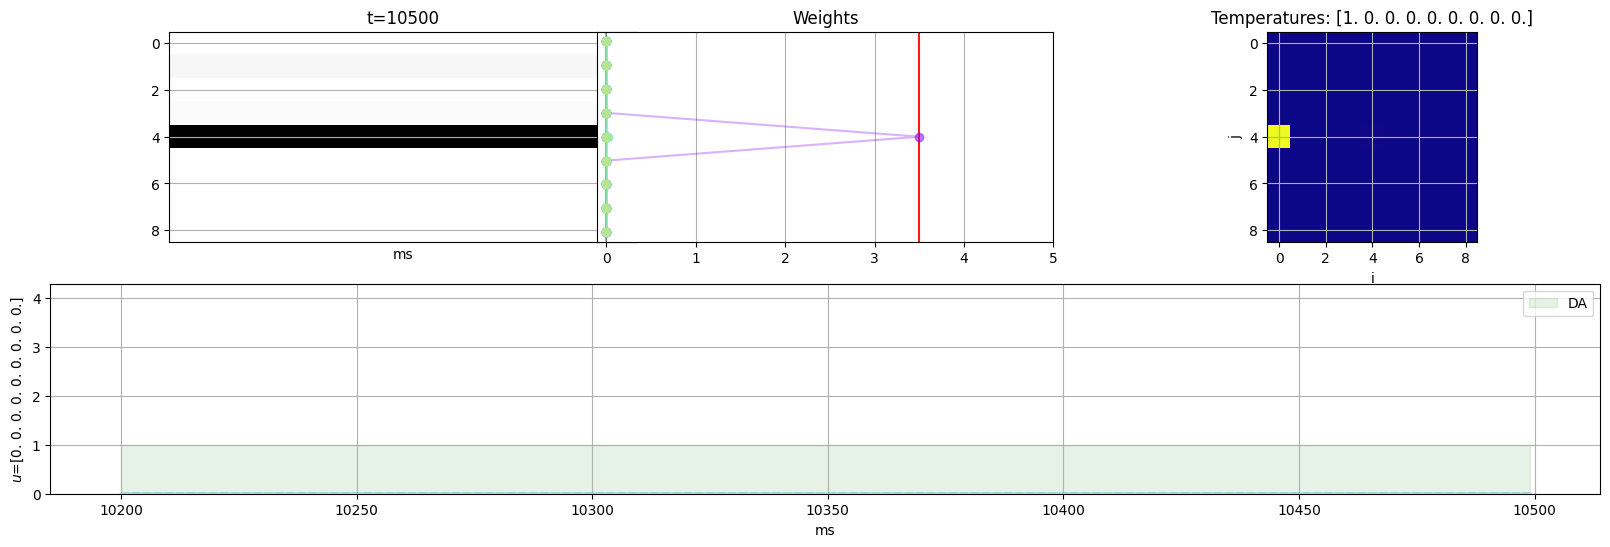

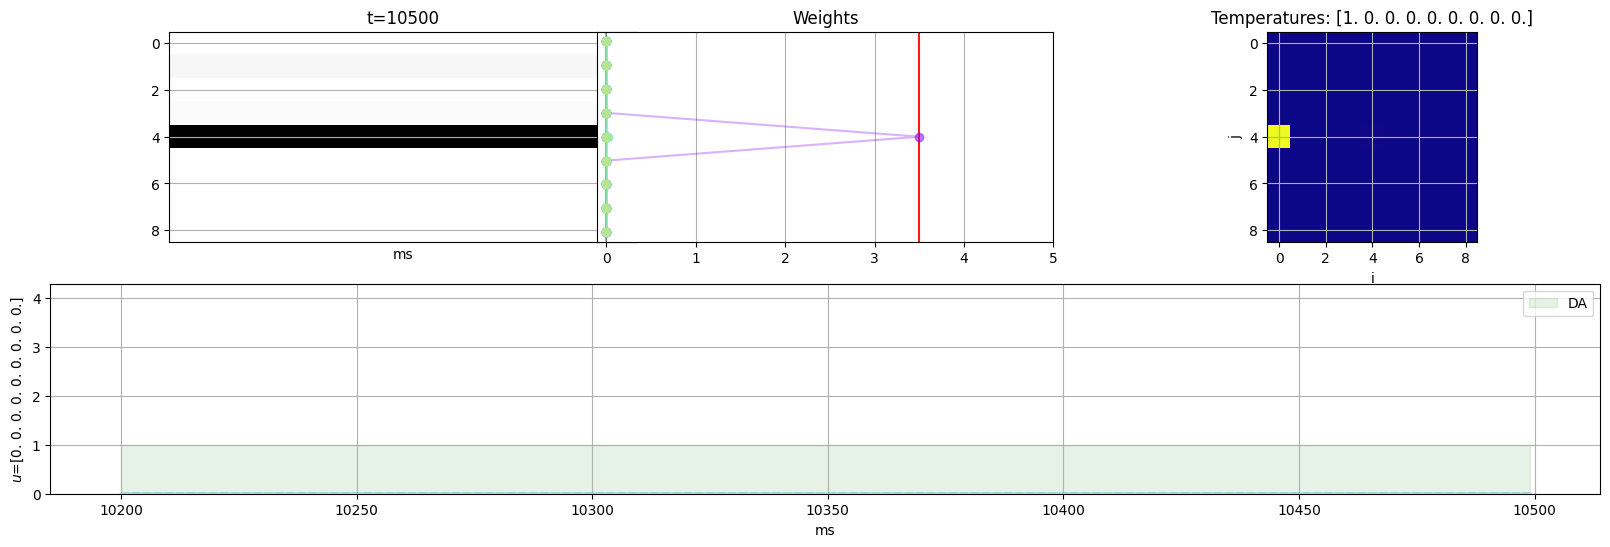

action q/c: q


In [999]:
N = 9
Nj = 9

""" Run """
genome['N'] = N
genome['Nj'] = Nj
genome['plastic'] = True
genome['IS_magnitude'] = 6
genome['lr'] = 0.07
genome['tau'] = 10
genome['is_retuning'] = True
genome['theta_freq'] = 0.001
genome['theta_freq_increase'] = 0.3
genome['wff_tau'] = 500
model = mm.RateNetwork7(**genome)

# Create an animal
speed = 0.001
animal = it.AnimalTrajectory(dt=0.002, 
                             prob_turn=0.1, 
                             prob_speed=0.0,
                             prob_rest=0.0, 
                             day_cycle=False)

# Create a trajectory
trajectory_pc = animal.make_trajectory(duration=40000, whole=False, dx=1, normalize=0, turning_scale=1, speed=1)

# inputs - HD, PC
layer = it.HDLayer(N=Nj, sigma=0.01)
layer_pc = it.PlaceLayer(N=Nj, sigma=0.04)
inputs_hd = layer.parse_trajectory(trajectory=np.linspace(0, T*speed, len(period)))
inputs_pc = layer_pc.parse_trajectory(trajectory=trajectory_pc)

# select
#inputs = inputs_hd
inputs = inputs_pc

record = np.zeros((N+1, len(inputs)))
Ix = np.zeros((N, len(inputs)))
X2 = np.zeros((len(inputs) + 10, Nj))

for t, x in enumerate(inputs):
    try:
        model.step(x=x.reshape(-1, 1))
        record[1:, t] = model.u.flatten()
        record[0, t] = model.DA
        Ix[:, t] = model.Is.flatten()
        
        X2[10:t+10] = inputs[:t]
    
        if t % 500 == 0:
            mv.plotting(model=model, X=X2, t=t, record=record, Ix=Ix, colors=colors)
            print(f"freq={model._theta_freq:.4f}")
            
    except KeyboardInterrupt:
        print('[paused]')
        clf()
        mv.plotting(model=model, X=X2, t=t, record=record, Ix=Ix, colors=colors)
        plt.show()
        while True:
            try:
                response = input("action q/c:")
                if response in ('quit', 'q', 'qq', 'c', ' '):
                    break
                print('[resume]')
                plt.show()
            except KeyboardInterrupt:
                print('[resuming...]')
                continue
        if response in ('quit', 'q', 'qq'):
            break

#### Training - *compact*

2023-12-13 18:58:06 | Training Model=<class 'src.mod_models.RateNetwork7'> with N=8 and Nj=8, [1 trials]
2023-12-13 18:58:06 | Using func=<function eval_func at 0x16a2d11c0>
100%|██████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 24246.51it/s]


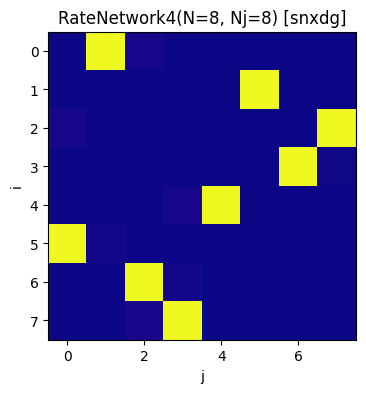

2023-12-13 18:58:11 | #i for j: 1.00
2023-12-13 18:58:11 | #j for i: 1.00


In [268]:
N = 8
Nj = 8

nb = 1
genome['N'] = N
genome['Nj'] = Nj
genome['plastic'] = True
genome['IS_magnitude'] = 6
genome['lr'] = 0.05
genome['tau'] = 4
genome['is_retuning'] = True
genome['theta_freq'] = 0.001
genome['theta_freq_increase'] = 0.3
genome['wff_tau'] = 500

# inputs
speed = 0.001
layer = it.HDLayer(N=Nj, sigma=0.01)
inputs = layer.parse_trajectory(trajectory=np.linspace(0, T*speed, len(period)))

model, record = mm.train_model(genome=genome, 
                               N=N, Nj=Nj, data=inputs, nb=nb,
                               Model=mm.RateNetwork7, display=True, 
                               ignore_zero=True,
                              )

# plot
if 1:
    plt.figure(figsize=(4, 4))
    plt.imshow(model.Wff, cmap='plasma')
    plt.title(f"{model}")
    plt.xlabel('j')
    plt.ylabel('i')
    plt.show()

logger.info(f"#i for j: {record[0].mean():.2f}")
logger.info(f"#j for i: {record[1].mean():.2f}")

## Simulation -1 - *Spatial tuning*
---

#### Circular domain

**Train**

In [258]:
N, Nj = 10, 10
genome['N'] = N
genome['Nj'] = Nj

Tmax = 4*np.pi
dt = 0.01
period = np.arange(0, T, dt)

# inputs
speed = 0.005
layer = it.HDLayer(N=Nj, sigma=0.01)
inputs = layer.parse_trajectory(trajectory=np.linspace(0, T*speed, len(period)))

record = np.empty((N, len(X)))

# initialization
model = mm.RateNetwork6(**genome)

for t, x in tqdm_enumerate(X):
    model.step(x=x.reshape(-1, 1))
    record[:, t] = model.u.flatten()

plt.figure(figsize=(4, 4))
plt.imshow(model.Wff, cmap='plasma')
plt.title(f"{model} | [0]eval={eval_func(model, axis=0):.3f} [1]eval={eval_func(model, axis=1):.3f}")
plt.xlabel('j')
plt.ylabel('i')
plt.show()

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 10)

**Test**

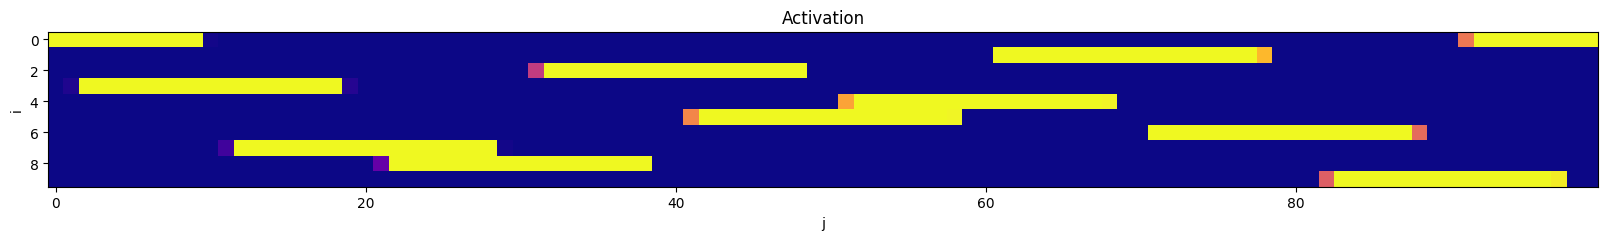

In [49]:
Tmax = 2*np.pi
dt = 0.1

# input
layer = it.HDLayer(N=genome['Nj'], sigma=0.015)
trajectory = np.linspace(0, Tmax, 100, endpoint=True)
duration = len(trajectory)
X = layer.parse_trajectory(trajectory=trajectory)

record = np.empty((genome['N'], len(X)))

for t, x in enumerate(X):
    model.step(x=x.reshape(-1, 1))
    record[:, t] = model.u.flatten()

plt.figure(figsize=(20, 4))
plt.imshow(record, cmap='plasma')
plt.title(f"Activation")
plt.xlabel('j')
plt.ylabel('i')
plt.show()

**Visualization**

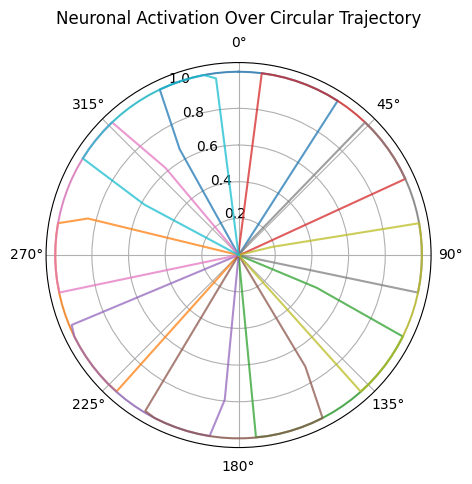

In [50]:
theta = np.linspace(0, 2 * np.pi, len(X))  # Time steps mapped to angles

plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)

for i in range(N):
    activation = record[i]
    ax.plot(theta, activation, alpha=0.75)

ax.set_theta_zero_location('N')  # Set 0 degrees at the top
ax.set_theta_direction(-1)  # Clockwise
ax.set_rlabel_position(-22.5)  # Position of radial labels
ax.set_title("Neuronal Activation Over Circular Trajectory", va='bottom')
#plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()



#### 2D domain

In [ ]:
def plot_activation(activation):

    size, N = activation.shape
    sqrtsize = int(np.sqrt(size))

    _, axs = plt.subplots(int(np.sqrt(N)), int(np.sqrt(N)), figsize=(5, 5))
    i = 0
    for row in axs:
        for ax in row:
            ax.imshow(np.flip(activation[:, i].reshape(sqrtsize, sqrtsize), axis=0), cmap='plasma')
            ax.axis('off')
            i += 1
    plt.show()

**Model**

In [1199]:
genome_1 = {'gain': 30.0,
 'bias': 2.5,
 'lr': 0.1,
 'tau': 40,
 'wff_std': 0.001,
 'wff_min': 0.0,
 'wff_max': 3.5,
 'wff_tau': 950,
 'rule': 'hebb',
 'std_tuning': 0.001,
 'soft_beta': 90,
 'dt': 0.0004,
 'N': N,
 'Nj': Nj,
 'DA_tau': 3,
 'bias_scale': 0.055,
 'bias_decay': 75,
}

genome_2 = {
    'gain': 30.0,
          'bias': 2.5,
          'lr': 0.05,
          'tau': 5,
          'wff_std': 0.001,
          'wff_min': 0.0,
          'wff_max': 3.5,
          'wff_tau': 500,
          'std_tuning': 0.001,
          'soft_beta': 20,
          'dt': 1,
          'N': N,
          'Nj': Nj,
          'DA_tau': 5,
          'bias_scale': 0.055,
          'bias_decay': 75,
          'IS_magnitude': 6,
          'theta_freq': 0.001,
          'theta_freq_increase': 0.2,
          'is_retuning': True,
          'nb_per_cycle': 4,
          'plastic': True,
          'nb_skip': 1,
}

**Train**

100%|████████████████████████████████████████████████████████████████| 10201/10201 [00:00<00:00, 45278.40it/s]


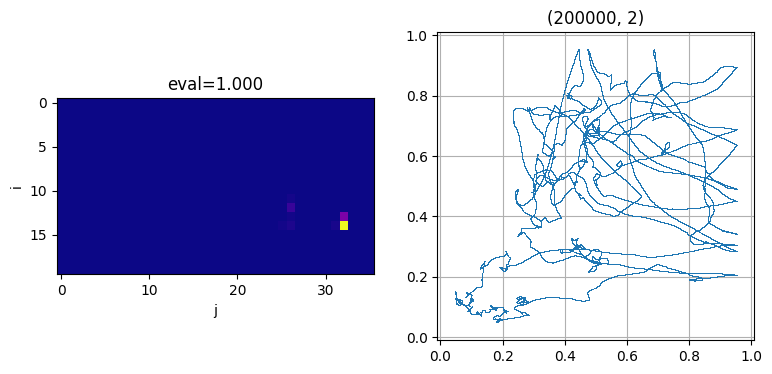

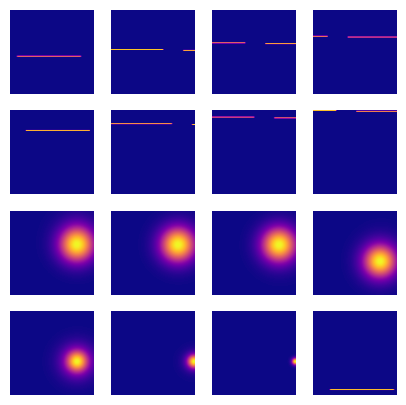

In [1198]:
# setting
N, Nj = 20, 36
genome_1['N'] = N
genome_1['Nj'] = Nj
genome_2['N'] = N
genome_2['Nj'] = Nj

# input
layer = it.PlaceLayer(N=Nj, sigma=0.04)
whole_track = it.AnimalTrajectory.whole_walk(dx=0.01)

# Create an animal
animal = it.AnimalTrajectory(dt=0.02, 
                             prob_turn=0.01, 
                             prob_speed=0.0,
                             prob_rest=0.0, 
                             day_cycle=False)

# Create a trajectory
trajectory = animal.make_trajectory(duration=600_000, whole=False, dx=1, normalize=0, turning_scale=0.1, speed=1)

X = layer.parse_trajectory(trajectory=trajectory)
X_whole = layer.parse_trajectory(trajectory=whole_track)

record = np.empty((N, len(X_whole)))

# initialization
#model = mm.RateNetwork6(**genome_1)
model = mm.RateNetwork7(**genome_2)

# training
for t, x in tqdm_enumerate(X):
    model.step(x=x.reshape(-1, 1))

# test
model._plastic = False
for t, x in tqdm_enumerate(X_whole):
    model.step(x=x.reshape(-1, 1))   
    record[:, t] = model.u.flatten()

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.imshow(model.Wff, cmap='plasma')
plt.title(f"eval={mm.eval_func(model, ignore_zero=True):.3f}")
plt.xlabel('j')
plt.ylabel('i')

plt.subplot(122)
plt.plot(trajectory[:, 0], trajectory[:, 1], ',')
plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()
plt.title(trajectory.shape)
plt.show()

plot_activation(record.T)

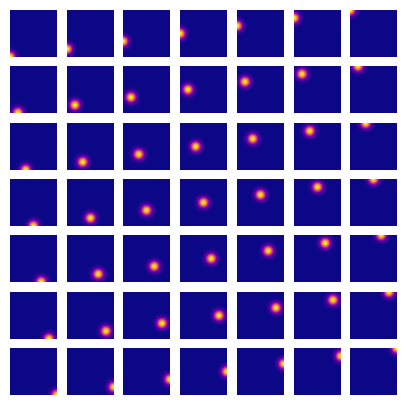

In [1149]:
plot_activation(X_whole)

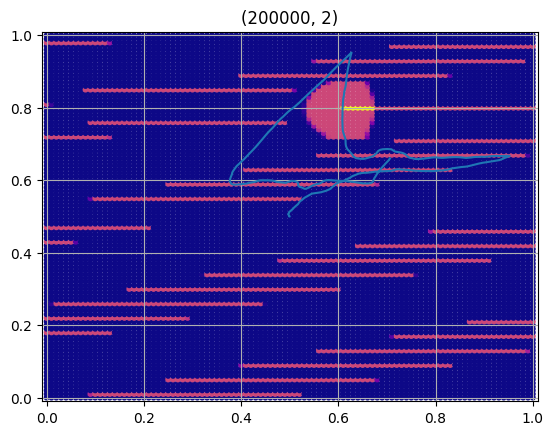

In [1195]:
plt.plot(trajectory[:, 0], trajectory[:, 1])

z = np.zeros(len(record[0]))
for i in range(N):
    z += np.where(record[i], record[i], 0)
    #print(z.shape)
    #print(trajectory.shape)
#plt.scatter(whole_track[:, 0], whole_track[:, 1], c=record[7], s=10, cmap='plasma')
plt.scatter(whole_track[:, 0], whole_track[:, 1], c=z, s=10, cmap='plasma')

plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()
plt.title(trajectory.shape)
plt.show()

In [1133]:
z

array([0., 0., 0., ..., 0., 0., 0.])